# HW5

The LendingClub is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this homework, you will build classification models to predict whether or not a loan provided by LendingClub is likely to default. 
<br>
<br>
In this homework you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be charged off and possibly go into default.

### 1. Load the Lending Club dataset

Load the dataset into a data frame named <b>loans</b>.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from scipy import sparse
%matplotlib inline

** included the low_memory field due to `error` message without it

In [2]:
loans = pd.read_csv("lending-club-data.csv", index_col = 0, low_memory = False)

In [3]:
loans.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,Ryder,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,NaN,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,Veolia Transportaton,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [4]:
len(loans)

122607

In [5]:
len(loans.columns)

67

### 2. Exploring features

Let's quickly explore what the dataset looks like. First, print out the column names to see what features we have in this dataset. Here, we should see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc.

In [6]:
loans.columns

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_grade_num

### 3. Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are described below. Extract these feature columns and target column from the dataset. We will only use these features.

In [7]:
features = ['grade', # grade of the loan 
            'sub_grade', # sub-grade of the loan 
            'short_emp', # one year or less of employment 
            'emp_length_num', # number of years of employment 
            'home_ownership', # home_ownership status: own, mortgage or rent 
            'dti', # debt to income ratio 
            'purpose', # the purpose of the loan 
            'term', # the term of the loan 
            'last_delinq_none', # has borrower had a delinquincy 
            'last_major_derog_none', # has borrower had 90 day or worse rating 
            'revol_util', # percent of available credit being used 
            'total_rec_late_fee'] # total late fees received to day

You may skip observations with missing values in these features.

In [8]:
loans2 = loans[features]

In [9]:
loans2.isna().sum()

grade                    0
sub_grade                0
short_emp                0
emp_length_num           0
home_ownership           0
dti                      0
purpose                  0
term                     0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
dtype: int64

There are no missing values in these features.

### 4. Exploring the target column

The target column (label column) of the dataset that we are interested in is called bad_loans. In this column <b>1</b> means a risky (bad) loan <b>0</b> means a safe loan.

(array([99457.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 23150.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

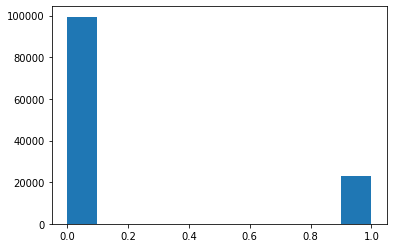

In [10]:
plt.hist(data = loans, x = 'bad_loans')

Now, let us explore the distribution of the target column. This gives us a sense of how many safe and risky loans are present in the dataset. Print out the percentage of safe loans and risky loans in the data frame.

In [11]:
bl = loans.groupby('bad_loans').size()

In [12]:
bl_percent = bl.to_frame()
bl_percent.reset_index(inplace = True)
bl_percent.rename(columns = {0: 'num_of_loan'}, inplace = True)

In [13]:
total = bl_percent.num_of_loan.sum()

In [14]:
bl_percent['Percentage'] = [bl_percent.num_of_loan[0] / total , bl_percent.num_of_loan[1] / total]

In [15]:
bl_percent

,bad_loans,num_of_loan,Percentage
0,0,99457,0.811185
1,1,23150,0.188815


Approximately <b>81%</b> of the loans are considered <i>safe loans</i>.

Therefore, it looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

### 5. Sample data to balance classes

Our data is disproportionally full of safe loans. Let's create two datasets: one with just the safe loans (safe_loans_raw) and one with just the risky loans (risky_loans_raw).

In [16]:
safe_loans_raw = loans[loans['bad_loans'] == 0]

In [17]:
len(safe_loans_raw)

99457

In [18]:
risky_loans_raw = loans[loans['bad_loans'] == 1]

In [19]:
len(risky_loans_raw)

23150

One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We will use seed=1 so everyone gets the same results. Use the following codes for this task.

** Changed seed to random_state as it was causing errors
<br>
Link <a href = "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html">here</a>

You can verify now that <b>loans_data</b> is comprised of approximately 50% safe loans and 50% risky loans.

In [20]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes 
# and use that percentage to undersample the safe loans. 

percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw 
safe_loans = safe_loans_raw.sample(frac = percentage, random_state = 1) 

# Append the risky_loans with the downsampled version of safe_loans 
loans_data = risky_loans.append(safe_loans)

In [21]:
print("Percentage of safe loans:", len(safe_loans) / float(len(loans_data)))
print("Percentage of risky loans:", len(risky_loans) / float(len(loans_data)))
print("Total number of loans in our new dataset:", len(loans_data))

Percentage of safe loans: 0.5
Percentage of risky loans: 0.5
Total number of loans in our new dataset: 46300


### 6. One-hot encoding

For scikit-learn's implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding.

### 7. Split data into training and validation and test sets

First, split the original data into train-validate set (90%) and test set (10%) using random state = 0. Then, split the train-validate set into training set (80%) and validation set (20%) using random state = 0.

In [22]:
features2 = ['grade', # grade of the loan 
            'sub_grade', # sub-grade of the loan 
            'short_emp', # one year or less of employment 
            'emp_length_num', # number of years of employment 
            'home_ownership', # home_ownership status: own, mortgage or rent 
            'dti', # debt to income ratio 
            'purpose', # the purpose of the loan 
            'term', # the term of the loan 
            'last_delinq_none', # has borrower had a delinquincy 
            'last_major_derog_none', # has borrower had 90 day or worse rating 
            'revol_util', # percent of available credit being used 
            'total_rec_late_fee', 'bad_loans']

In [23]:
loans_data2 = loans_data[features2]

In [24]:
loans_data2.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,bad_loans
id,,,,,,,,,,,,,
1077430,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,1
1071795,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,1
1071570,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,1
1064687,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,1
1069057,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,1


** Used `pd.get_dummies` just for the visualization component of the Decision Tree Classifier - unsuccessful using OneHotEncoder

In [25]:
loans_data_new = pd.get_dummies(loans_data2, columns = ['grade', 'sub_grade', 'short_emp', 'home_ownership',
       'purpose', 'term', 'last_delinq_none', 'last_major_derog_none'])

In [26]:
X = loans_data_new.drop(columns = 'bad_loans')
y = loans_data_new.bad_loans

In [27]:
feature_col = ['emp_length_num', 'dti', 'revol_util', 'total_rec_late_fee',
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'short_emp_0', 'short_emp_1', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_ 36 months', 'term_ 60 months', 'last_delinq_none_0',
       'last_delinq_none_1', 'last_major_derog_none_0',
       'last_major_derog_none_1']

Split the original data into train-validate set (90%) and test set (10%) using random state = 0.

In [28]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 0)

Then, split the train-validate set into training set (80%) and validation set (20%) using random state = 0.

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify = y_trainval, test_size = 0.2, random_state = 0)

### 8. Build a decision tree classifier

Build a decision tree classifier with `max_depth = 2` or `6` or `10` using the training set.

Visualize your decision trees.

In [37]:
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree
import graphviz

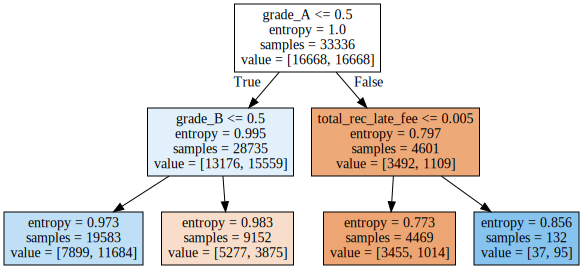

In [35]:
tree = DecisionTreeClassifier(max_depth=2, criterion='entropy').fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names = feature_col, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="no_pruning", cleanup=True)
graph

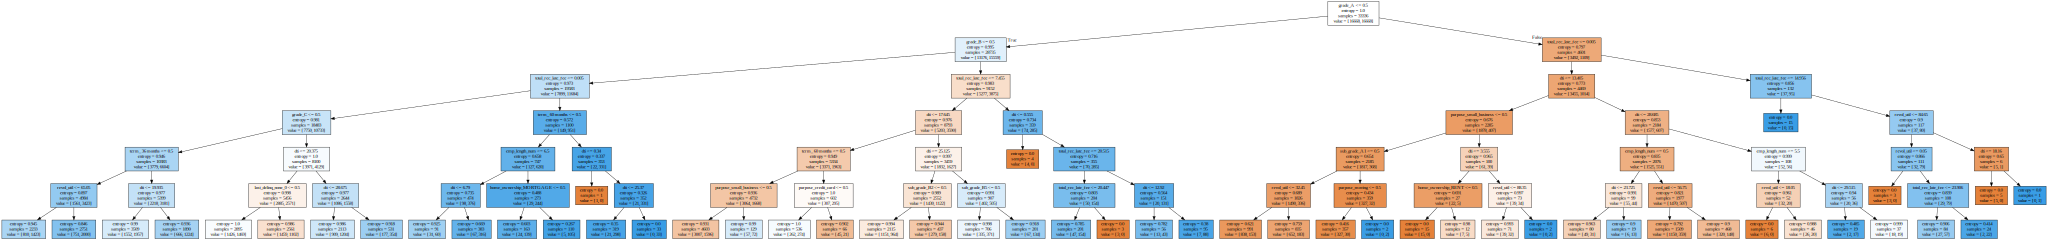

In [36]:
tree = DecisionTreeClassifier(max_depth=6, criterion='entropy').fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names = feature_col, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="no_pruning", cleanup=True)
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.669274 to fit


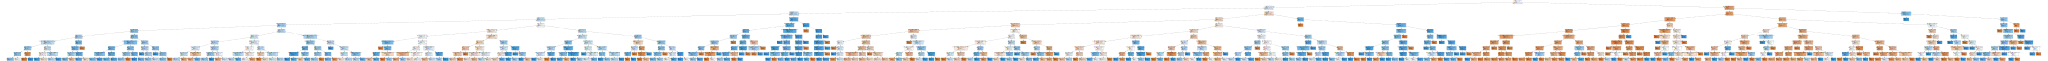

In [37]:
tree = DecisionTreeClassifier(max_depth=10, criterion='entropy').fit(X_train, y_train)
tree_dot = export_graphviz(tree, out_file=None, feature_names = feature_col, filled=True)
graph = graphviz.Source(tree_dot, format="png")
graph.render(filename="no_pruning", cleanup=True)
graph

In [30]:
X = loans_data2.drop(columns = 'bad_loans')
y = loans_data2.bad_loans

In [31]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 0)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify = y_trainval, test_size = 0.2, random_state = 0)

Scaling categorical features

In [33]:
col_cat = ['grade', 'sub_grade', 'short_emp', 'home_ownership',
       'purpose', 'term', 'last_delinq_none', 'last_major_derog_none']
col_num = ['emp_length_num', 'dti', 'revol_util', 'total_rec_late_fee']

X_train_cat = X_train[col_cat]
X_train_num = X_train[col_num]
X_test_cat = X_test[col_cat]
X_test_num = X_test[col_num]

In [34]:
pipe_cat = make_pipeline(SimpleImputer(strategy = 'constant'), OneHotEncoder(handle_unknown = 'ignore'))
pipe_num = make_pipeline(StandardScaler(), SimpleImputer())

In [35]:
preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

In [38]:
pipe = Pipeline([('preprocessing', preprocessor), ('classifier', DecisionTreeClassifier(criterion = "entropy", random_state = 0))])

In [39]:
param_grid = {'classifier__max_depth': [2, 6, 10]}
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, return_train_score=True)
grid.fit(X_train, y_train)

accuracy = grid.score(X_val, y_val)
print(grid.best_params_)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

{'classifier__max_depth': 6}
Accuracy score of the GridSearchCV is 0.627


<b>OR</b>

Decision Tree Classifier `max_depth = 2`

In [40]:
param_grid = {'classifier__max_depth': [2]}
grid_two = GridSearchCV(pipe, param_grid = param_grid, cv = 5, return_train_score=True)
grid_two.fit(X_train, y_train)

accuracy = grid_two.score(X_val, y_val)
print('Accuracy score of the {} is {:.3f}'.format(grid_two.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.608


Decision Tree Classifier `max_depth = 6`

In [41]:
param_grid = {'classifier__max_depth': [6]}
grid_six = GridSearchCV(pipe, param_grid = param_grid, cv = 5, return_train_score=True)
grid_six.fit(X_train, y_train)

accuracy = grid_six.score(X_val, y_val)
print('Accuracy score of the {} is {:.3f}'.format(grid_six.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.627


Decision Tree Classifier `max_depth = 10`

In [42]:
param_grid = {'classifier__max_depth': [10]}
grid_ten = GridSearchCV(pipe, param_grid = param_grid, cv = 5, return_train_score=True)
grid_ten.fit(X_train, y_train)

accuracy = grid_ten.score(X_val, y_val)
print('Accuracy score of the {} is {:.3f}'.format(grid_ten.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.626


<b><i>The performance was the best with the max_depth as 6.

In [43]:
accuracy = grid_six.score(X_test, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid_six.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.637


### 9. Explore probability predictions

For each row in the <b>validation set</b>, what is the probability (using the best model from the previous comparisons) of a loan being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)
<br>
<br>
Which loan has the highest probability of being classified as a <b>safe loan</b>?

<b>0 = Safe Loans</b> and <b>1 = Risky Loans</b>

In [44]:
predictions = pd.DataFrame(grid_six.predict_proba(X_val), columns = grid_six.classes_)

In [45]:
predictions.rename(columns = {0: 'Safe_Loans', 1: 'Risky_Loans'}, inplace = True)

There are 5 loans that have the highest probability of being classified as a <b>safe loan</b>.

In [46]:
predictions.sort_values(by = ['Safe_Loans'], ascending = False).head()

,Safe_Loans,Risky_Loans
5884,1.0,0.0
762,1.0,0.0
6453,1.0,0.0
5110,1.0,0.0
401,1.0,0.0


In [47]:
loans_data2.reset_index(inplace = True)

In [48]:
loans_data2.loc[[5684, 762, 6453, 5110, 401]]

,id,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,bad_loans
5684,388278,G,G2,0,3,RENT,13.19,small_business,36 months,1,1,42.3,14.9571,1
762,990043,A,A4,0,8,RENT,1.11,debt_consolidation,36 months,0,1,4.7,14.9808,1
6453,8590555,C,C3,1,1,RENT,22.91,credit_card,36 months,1,1,34.8,0.0000,1
5110,355228,C,C1,1,1,RENT,16.86,credit_card,36 months,1,1,49.9,0.0000,1
401,1033033,C,C2,0,11,RENT,14.69,debt_consolidation,36 months,1,1,78.8,0.0000,1


It seems like id `990043` could be the safest as the debt to income ratio (dti) is the lowest indicating a higher likelihood of paying back the loan.

### 10. Build a SVM classifier

Use 5-fold GridSearchCV on the train-validate set. Build a kernelized SVM classifier (preprocessing the data with MinMaxScaler) with rbf kernel and compare hyperparameters in the following grid:
<br>
<br>
`C: np.logspace(-3, 3, 7), gamma: np.logspace(-3, 3, 7) / X_train.shape[0]`
<br>
<br>
Report the best model’s performance on the test set.

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [50]:
pipe_cat = make_pipeline(SimpleImputer(strategy = 'constant'), OneHotEncoder(handle_unknown = 'ignore'))
pipe_num_svm = make_pipeline(MinMaxScaler(), SimpleImputer())

In [51]:
preprocessor_svm = make_column_transformer((pipe_cat, col_cat), (pipe_num_svm, col_num))

In [52]:
pipe_svc = Pipeline([('preprocessing', preprocessor_svm), ('classifier', SVC(kernel = 'rbf'))])

In [53]:
np.set_printoptions(precision = 6, suppress = True)
param_grid = {'classifier__C': np.logspace(-2, 2, 2),
              'classifier__gamma': np.logspace(-2, 2, 2) / X_train.shape[0]}

In [55]:
grid = GridSearchCV(pipe_svc, param_grid = param_grid, cv = 5, return_train_score = True)
grid.fit(X_trainval, y_trainval)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                      

In [56]:
grid.best_params_

{'classifier__C': 100.0, 'classifier__gamma': 0.002999760019198464}

In [57]:
accuracy = grid.score(X_test, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.630


### 11. Build a random forest classifier

Use 5-fold GridSearchCV on the train-validate set. Build a random forest classifier and compare hyperparameters in the following grid: 
<br>
<br>
<i>max_features: [2, 4, 6, 8, 10], max_depth: [6, 8, 10, 12, 14]</i>
<br>
<br>
Report the best model’s performance on the test set.

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
pipe_cat = make_pipeline(SimpleImputer(strategy = 'constant'), OneHotEncoder(handle_unknown = 'ignore'))
pipe_num = make_pipeline(StandardScaler(), SimpleImputer())

In [60]:
preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

In [61]:
pipe_rf = Pipeline([('preprocessing', preprocessor), ('classifier', RandomForestClassifier())])

In [62]:
param_grid = {'classifier__max_features': [2, 4, 6, 8, 10],
              'classifier__max_depth': [6, 8, 10, 12, 14]}

In [63]:
grid = GridSearchCV(pipe_rf, param_grid = param_grid, cv = 5, return_train_score=True)
grid.fit(X_trainval, y_trainval)

grid.best_params_

{'classifier__max_depth': 12, 'classifier__max_features': 10}

In [64]:
accuracy = grid.score(X_test, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.651


### 12. Build a gradient boosting classifier

Use 5-fold GridSearchCV on the train-validate set. Build a gradient boosted tree classifier (fixing max_depth = 6) and compare hyperparameters in the following grid:
<br>
<br>
<i>learning_rate: np.logspace(-2, 0, 3), n_estimators: [5, 10, 50, 100, 200, 500]</i>
<br>
<br>
Report the best model’s performance on the test set.

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

In [66]:
pipe_gb = Pipeline([('preprocessing', preprocessor), ('classifier', GradientBoostingClassifier(max_depth = 6))])

** Didn't use the code below because it took too long to load (wouldn't load after 1 hour)

In [ ]:
#param_grid = {'classifier__learning_rate': np.logspace(-2, 0, 3),
              #'classifier__n_estimators': [5, 10, 50, 100, 200, 500]}

** Reduced the number of estimators to run the code faster

In [67]:
param_grid = {'classifier__learning_rate': np.logspace(-2, 0, 3),
              'classifier__n_estimators': [5, 10, 50, 100]}

In [68]:
grid = GridSearchCV(pipe_gb, param_grid = param_grid, cv = 5, return_train_score=True)
grid.fit(X_trainval, y_trainval)

accuracy = grid.score(X_test, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.647


### 13. XGBoost, LightGBM, and CatBoost

Try <b>XGBoost</b>, <b>LightGBM</b>, and <b>CatBoost</b> and see if you can get further improvement. 
<br>Report the best model’s performance on the test set.

In [78]:
from xgboost import XGBClassifier

In [73]:
pipe_xboost = Pipeline([('preprocessing', preprocessor), ('classifier', XGBClassifier(eval_metric='mlogloss', use_label_encoder =False))])

In [74]:
param_grid = {'classifier__gamma': [0.001, 0.01, 0.1, 1, 10],
              'classifier__n_estimators': [100, 200, 300]}

In [80]:
grid = GridSearchCV(pipe_xboost, param_grid = param_grid, cv = 5, return_train_score=True)
grid.fit(X_trainval, y_trainval)

[01:05:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

[01:06:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:06:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:06:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

[01:08:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:08:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:08:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

[01:09:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:09:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:09:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameter

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                      

In [81]:
accuracy = grid.score(X_test, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.647


** lightgbm installation on macOS:
<br>1. Downgrade pip to 19.3.4
<br>2. Run `pip install open-mpi`
<br>3. Then run `brew install lightgbm`
<br>4. Finally run `pip install lightgbm`

In [82]:
from lightgbm import LGBMClassifier

In [83]:
pipe_lightgbm = Pipeline([('preprocessing', preprocessor), ('classifier', LGBMClassifier())])

In [84]:
param_grid = {'classifier__max_depth': [2, 6, 8],
              'classifier__n_estimators': [100, 1000, 5000]}

In [85]:
grid = GridSearchCV(pipe_lightgbm, param_grid = param_grid, cv = 5, return_train_score=True)
grid.fit(X_trainval, y_trainval)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                      

In [86]:
accuracy = grid.score(X_test, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.651


In [87]:
from catboost import CatBoostClassifier

In [88]:
pipe_catboost = Pipeline([('preprocessing', preprocessor), ('classifier', CatBoostClassifier())])

In [89]:
param_grid = {'classifier__learning_rate': [0.01, 0.1, 1]}

In [90]:
grid = GridSearchCV(pipe_catboost, param_grid = param_grid, cv = 5, return_train_score=True)
grid.fit(X_trainval, y_trainval)

0:	learn: 0.6919953	total: 62.4ms	remaining: 1m 2s
1:	learn: 0.6908026	total: 69ms	remaining: 34.4s
2:	learn: 0.6896806	total: 74ms	remaining: 24.6s
3:	learn: 0.6885647	total: 78.5ms	remaining: 19.6s
4:	learn: 0.6874091	total: 83.1ms	remaining: 16.5s
5:	learn: 0.6863559	total: 87.7ms	remaining: 14.5s
6:	learn: 0.6852976	total: 91.9ms	remaining: 13s
7:	learn: 0.6842342	total: 96.6ms	remaining: 12s
8:	learn: 0.6832927	total: 101ms	remaining: 11.1s
9:	learn: 0.6822960	total: 106ms	remaining: 10.5s
10:	learn: 0.6813364	total: 110ms	remaining: 9.93s
11:	learn: 0.6804119	total: 115ms	remaining: 9.47s
12:	learn: 0.6794217	total: 120ms	remaining: 9.09s
13:	learn: 0.6784969	total: 127ms	remaining: 8.94s
14:	learn: 0.6775997	total: 131ms	remaining: 8.63s
15:	learn: 0.6767194	total: 136ms	remaining: 8.39s
16:	learn: 0.6758259	total: 141ms	remaining: 8.15s
17:	learn: 0.6749412	total: 145ms	remaining: 7.93s
18:	learn: 0.6741179	total: 150ms	remaining: 7.73s
19:	learn: 0.6733244	total: 154ms	remaini

162:	learn: 0.6323459	total: 1.04s	remaining: 5.34s
163:	learn: 0.6322550	total: 1.04s	remaining: 5.33s
164:	learn: 0.6321674	total: 1.05s	remaining: 5.32s
165:	learn: 0.6320775	total: 1.06s	remaining: 5.31s
166:	learn: 0.6319916	total: 1.06s	remaining: 5.31s
167:	learn: 0.6319115	total: 1.07s	remaining: 5.3s
168:	learn: 0.6318148	total: 1.07s	remaining: 5.29s
169:	learn: 0.6317297	total: 1.08s	remaining: 5.28s
170:	learn: 0.6316576	total: 1.08s	remaining: 5.26s
171:	learn: 0.6315578	total: 1.09s	remaining: 5.25s
172:	learn: 0.6314764	total: 1.1s	remaining: 5.25s
173:	learn: 0.6313943	total: 1.1s	remaining: 5.23s
174:	learn: 0.6313383	total: 1.11s	remaining: 5.22s
175:	learn: 0.6312516	total: 1.11s	remaining: 5.21s
176:	learn: 0.6311746	total: 1.12s	remaining: 5.21s
177:	learn: 0.6310908	total: 1.13s	remaining: 5.2s
178:	learn: 0.6310298	total: 1.13s	remaining: 5.18s
179:	learn: 0.6309598	total: 1.13s	remaining: 5.17s
180:	learn: 0.6308667	total: 1.14s	remaining: 5.16s
181:	learn: 0.63

322:	learn: 0.6238831	total: 2.01s	remaining: 4.22s
323:	learn: 0.6238546	total: 2.02s	remaining: 4.21s
324:	learn: 0.6238144	total: 2.03s	remaining: 4.21s
325:	learn: 0.6237874	total: 2.03s	remaining: 4.21s
326:	learn: 0.6237528	total: 2.04s	remaining: 4.2s
327:	learn: 0.6237210	total: 2.04s	remaining: 4.19s
328:	learn: 0.6236961	total: 2.05s	remaining: 4.18s
329:	learn: 0.6236657	total: 2.06s	remaining: 4.17s
330:	learn: 0.6236339	total: 2.06s	remaining: 4.17s
331:	learn: 0.6236094	total: 2.06s	remaining: 4.16s
332:	learn: 0.6235715	total: 2.07s	remaining: 4.15s
333:	learn: 0.6235412	total: 2.08s	remaining: 4.14s
334:	learn: 0.6235148	total: 2.08s	remaining: 4.13s
335:	learn: 0.6234822	total: 2.09s	remaining: 4.13s
336:	learn: 0.6234499	total: 2.09s	remaining: 4.12s
337:	learn: 0.6234195	total: 2.1s	remaining: 4.11s
338:	learn: 0.6233899	total: 2.1s	remaining: 4.1s
339:	learn: 0.6233563	total: 2.11s	remaining: 4.09s
340:	learn: 0.6233357	total: 2.11s	remaining: 4.08s
341:	learn: 0.62

482:	learn: 0.6198990	total: 2.8s	remaining: 3s
483:	learn: 0.6198825	total: 2.8s	remaining: 2.99s
484:	learn: 0.6198670	total: 2.81s	remaining: 2.98s
485:	learn: 0.6198455	total: 2.81s	remaining: 2.98s
486:	learn: 0.6198222	total: 2.82s	remaining: 2.97s
487:	learn: 0.6198122	total: 2.82s	remaining: 2.96s
488:	learn: 0.6197841	total: 2.83s	remaining: 2.96s
489:	learn: 0.6197630	total: 2.84s	remaining: 2.95s
490:	learn: 0.6197391	total: 2.84s	remaining: 2.95s
491:	learn: 0.6197212	total: 2.85s	remaining: 2.94s
492:	learn: 0.6197041	total: 2.86s	remaining: 2.94s
493:	learn: 0.6196883	total: 2.86s	remaining: 2.93s
494:	learn: 0.6196707	total: 2.87s	remaining: 2.93s
495:	learn: 0.6196549	total: 2.88s	remaining: 2.92s
496:	learn: 0.6196263	total: 2.88s	remaining: 2.92s
497:	learn: 0.6196007	total: 2.89s	remaining: 2.92s
498:	learn: 0.6195820	total: 2.9s	remaining: 2.91s
499:	learn: 0.6195617	total: 2.91s	remaining: 2.91s
500:	learn: 0.6195421	total: 2.91s	remaining: 2.9s
501:	learn: 0.61952

656:	learn: 0.6168848	total: 3.77s	remaining: 1.97s
657:	learn: 0.6168752	total: 3.77s	remaining: 1.96s
658:	learn: 0.6168727	total: 3.78s	remaining: 1.96s
659:	learn: 0.6168540	total: 3.79s	remaining: 1.95s
660:	learn: 0.6168340	total: 3.79s	remaining: 1.94s
661:	learn: 0.6168202	total: 3.8s	remaining: 1.94s
662:	learn: 0.6168061	total: 3.8s	remaining: 1.93s
663:	learn: 0.6167800	total: 3.81s	remaining: 1.93s
664:	learn: 0.6167623	total: 3.82s	remaining: 1.92s
665:	learn: 0.6167451	total: 3.82s	remaining: 1.92s
666:	learn: 0.6167316	total: 3.83s	remaining: 1.91s
667:	learn: 0.6167077	total: 3.83s	remaining: 1.91s
668:	learn: 0.6166861	total: 3.84s	remaining: 1.9s
669:	learn: 0.6166713	total: 3.84s	remaining: 1.89s
670:	learn: 0.6166475	total: 3.85s	remaining: 1.89s
671:	learn: 0.6166344	total: 3.86s	remaining: 1.88s
672:	learn: 0.6166191	total: 3.86s	remaining: 1.88s
673:	learn: 0.6166063	total: 3.87s	remaining: 1.87s
674:	learn: 0.6165898	total: 3.87s	remaining: 1.86s
675:	learn: 0.6

846:	learn: 0.6142320	total: 4.74s	remaining: 857ms
847:	learn: 0.6142197	total: 4.75s	remaining: 851ms
848:	learn: 0.6142123	total: 4.76s	remaining: 846ms
849:	learn: 0.6141985	total: 4.76s	remaining: 840ms
850:	learn: 0.6141901	total: 4.76s	remaining: 834ms
851:	learn: 0.6141816	total: 4.77s	remaining: 828ms
852:	learn: 0.6141675	total: 4.77s	remaining: 823ms
853:	learn: 0.6141598	total: 4.78s	remaining: 817ms
854:	learn: 0.6141428	total: 4.78s	remaining: 811ms
855:	learn: 0.6141271	total: 4.79s	remaining: 805ms
856:	learn: 0.6141055	total: 4.79s	remaining: 800ms
857:	learn: 0.6140938	total: 4.8s	remaining: 794ms
858:	learn: 0.6140672	total: 4.8s	remaining: 789ms
859:	learn: 0.6140560	total: 4.81s	remaining: 783ms
860:	learn: 0.6140428	total: 4.82s	remaining: 778ms
861:	learn: 0.6140312	total: 4.82s	remaining: 772ms
862:	learn: 0.6140102	total: 4.83s	remaining: 766ms
863:	learn: 0.6139965	total: 4.83s	remaining: 761ms
864:	learn: 0.6139819	total: 4.84s	remaining: 755ms
865:	learn: 0.

37:	learn: 0.6625928	total: 199ms	remaining: 5.04s
38:	learn: 0.6620567	total: 207ms	remaining: 5.09s
39:	learn: 0.6615706	total: 214ms	remaining: 5.14s
40:	learn: 0.6610419	total: 219ms	remaining: 5.12s
41:	learn: 0.6605343	total: 224ms	remaining: 5.1s
42:	learn: 0.6600337	total: 228ms	remaining: 5.08s
43:	learn: 0.6595204	total: 233ms	remaining: 5.05s
44:	learn: 0.6590520	total: 237ms	remaining: 5.04s
45:	learn: 0.6586000	total: 242ms	remaining: 5.01s
46:	learn: 0.6581164	total: 246ms	remaining: 4.99s
47:	learn: 0.6576743	total: 251ms	remaining: 4.98s
48:	learn: 0.6572254	total: 256ms	remaining: 4.97s
49:	learn: 0.6567977	total: 261ms	remaining: 4.95s
50:	learn: 0.6563541	total: 265ms	remaining: 4.93s
51:	learn: 0.6559187	total: 269ms	remaining: 4.91s
52:	learn: 0.6554961	total: 274ms	remaining: 4.89s
53:	learn: 0.6550734	total: 278ms	remaining: 4.87s
54:	learn: 0.6546820	total: 282ms	remaining: 4.85s
55:	learn: 0.6542746	total: 286ms	remaining: 4.83s
56:	learn: 0.6539205	total: 291m

205:	learn: 0.6313026	total: 971ms	remaining: 3.74s
206:	learn: 0.6312353	total: 978ms	remaining: 3.75s
207:	learn: 0.6311723	total: 984ms	remaining: 3.75s
208:	learn: 0.6311243	total: 988ms	remaining: 3.74s
209:	learn: 0.6310640	total: 994ms	remaining: 3.74s
210:	learn: 0.6310053	total: 998ms	remaining: 3.73s
211:	learn: 0.6309514	total: 1s	remaining: 3.73s
212:	learn: 0.6308939	total: 1.01s	remaining: 3.72s
213:	learn: 0.6308416	total: 1.01s	remaining: 3.72s
214:	learn: 0.6307978	total: 1.02s	remaining: 3.71s
215:	learn: 0.6307344	total: 1.02s	remaining: 3.71s
216:	learn: 0.6306811	total: 1.03s	remaining: 3.7s
217:	learn: 0.6306335	total: 1.03s	remaining: 3.7s
218:	learn: 0.6305787	total: 1.03s	remaining: 3.69s
219:	learn: 0.6305200	total: 1.04s	remaining: 3.69s
220:	learn: 0.6304571	total: 1.04s	remaining: 3.68s
221:	learn: 0.6303983	total: 1.05s	remaining: 3.67s
222:	learn: 0.6303369	total: 1.05s	remaining: 3.67s
223:	learn: 0.6302845	total: 1.06s	remaining: 3.66s
224:	learn: 0.630

371:	learn: 0.6248964	total: 1.74s	remaining: 2.94s
372:	learn: 0.6248729	total: 1.75s	remaining: 2.94s
373:	learn: 0.6248436	total: 1.76s	remaining: 2.94s
374:	learn: 0.6248150	total: 1.76s	remaining: 2.94s
375:	learn: 0.6247985	total: 1.77s	remaining: 2.93s
376:	learn: 0.6247807	total: 1.77s	remaining: 2.93s
377:	learn: 0.6247507	total: 1.77s	remaining: 2.92s
378:	learn: 0.6247269	total: 1.78s	remaining: 2.92s
379:	learn: 0.6247026	total: 1.78s	remaining: 2.91s
380:	learn: 0.6246725	total: 1.79s	remaining: 2.91s
381:	learn: 0.6246597	total: 1.79s	remaining: 2.9s
382:	learn: 0.6246349	total: 1.8s	remaining: 2.9s
383:	learn: 0.6246102	total: 1.8s	remaining: 2.89s
384:	learn: 0.6245899	total: 1.81s	remaining: 2.89s
385:	learn: 0.6245561	total: 1.81s	remaining: 2.88s
386:	learn: 0.6245287	total: 1.81s	remaining: 2.88s
387:	learn: 0.6245032	total: 1.82s	remaining: 2.87s
388:	learn: 0.6244803	total: 1.82s	remaining: 2.87s
389:	learn: 0.6244444	total: 1.83s	remaining: 2.86s
390:	learn: 0.62

538:	learn: 0.6213453	total: 2.54s	remaining: 2.18s
539:	learn: 0.6213258	total: 2.55s	remaining: 2.17s
540:	learn: 0.6213099	total: 2.55s	remaining: 2.17s
541:	learn: 0.6212955	total: 2.56s	remaining: 2.16s
542:	learn: 0.6212778	total: 2.57s	remaining: 2.16s
543:	learn: 0.6212647	total: 2.57s	remaining: 2.15s
544:	learn: 0.6212368	total: 2.58s	remaining: 2.15s
545:	learn: 0.6212277	total: 2.58s	remaining: 2.14s
546:	learn: 0.6212041	total: 2.58s	remaining: 2.14s
547:	learn: 0.6211865	total: 2.59s	remaining: 2.13s
548:	learn: 0.6211672	total: 2.59s	remaining: 2.13s
549:	learn: 0.6211482	total: 2.6s	remaining: 2.12s
550:	learn: 0.6211328	total: 2.6s	remaining: 2.12s
551:	learn: 0.6211167	total: 2.61s	remaining: 2.12s
552:	learn: 0.6210962	total: 2.62s	remaining: 2.11s
553:	learn: 0.6210816	total: 2.62s	remaining: 2.11s
554:	learn: 0.6210642	total: 2.63s	remaining: 2.11s
555:	learn: 0.6210467	total: 2.63s	remaining: 2.1s
556:	learn: 0.6210267	total: 2.64s	remaining: 2.1s
557:	learn: 0.62

708:	learn: 0.6185613	total: 3.33s	remaining: 1.36s
709:	learn: 0.6185441	total: 3.33s	remaining: 1.36s
710:	learn: 0.6185309	total: 3.34s	remaining: 1.36s
711:	learn: 0.6185141	total: 3.34s	remaining: 1.35s
712:	learn: 0.6185031	total: 3.35s	remaining: 1.35s
713:	learn: 0.6184915	total: 3.35s	remaining: 1.34s
714:	learn: 0.6184818	total: 3.36s	remaining: 1.34s
715:	learn: 0.6184658	total: 3.36s	remaining: 1.33s
716:	learn: 0.6184515	total: 3.37s	remaining: 1.33s
717:	learn: 0.6184357	total: 3.37s	remaining: 1.32s
718:	learn: 0.6184162	total: 3.37s	remaining: 1.32s
719:	learn: 0.6184068	total: 3.38s	remaining: 1.31s
720:	learn: 0.6183966	total: 3.38s	remaining: 1.31s
721:	learn: 0.6183797	total: 3.39s	remaining: 1.3s
722:	learn: 0.6183622	total: 3.39s	remaining: 1.3s
723:	learn: 0.6183369	total: 3.4s	remaining: 1.29s
724:	learn: 0.6183254	total: 3.4s	remaining: 1.29s
725:	learn: 0.6183104	total: 3.4s	remaining: 1.28s
726:	learn: 0.6182960	total: 3.41s	remaining: 1.28s
727:	learn: 0.618

880:	learn: 0.6161250	total: 4.11s	remaining: 555ms
881:	learn: 0.6161130	total: 4.12s	remaining: 551ms
882:	learn: 0.6161006	total: 4.12s	remaining: 546ms
883:	learn: 0.6160849	total: 4.13s	remaining: 542ms
884:	learn: 0.6160776	total: 4.13s	remaining: 537ms
885:	learn: 0.6160651	total: 4.14s	remaining: 532ms
886:	learn: 0.6160510	total: 4.14s	remaining: 528ms
887:	learn: 0.6160390	total: 4.15s	remaining: 523ms
888:	learn: 0.6160204	total: 4.15s	remaining: 518ms
889:	learn: 0.6160047	total: 4.16s	remaining: 514ms
890:	learn: 0.6159929	total: 4.16s	remaining: 509ms
891:	learn: 0.6159785	total: 4.16s	remaining: 504ms
892:	learn: 0.6159636	total: 4.17s	remaining: 500ms
893:	learn: 0.6159493	total: 4.17s	remaining: 495ms
894:	learn: 0.6159262	total: 4.18s	remaining: 490ms
895:	learn: 0.6159059	total: 4.18s	remaining: 486ms
896:	learn: 0.6158903	total: 4.19s	remaining: 481ms
897:	learn: 0.6158703	total: 4.19s	remaining: 476ms
898:	learn: 0.6158525	total: 4.2s	remaining: 471ms
899:	learn: 0

41:	learn: 0.6611194	total: 204ms	remaining: 4.65s
42:	learn: 0.6606369	total: 213ms	remaining: 4.74s
43:	learn: 0.6601364	total: 225ms	remaining: 4.89s
44:	learn: 0.6596736	total: 232ms	remaining: 4.93s
45:	learn: 0.6592085	total: 239ms	remaining: 4.95s
46:	learn: 0.6587571	total: 243ms	remaining: 4.94s
47:	learn: 0.6583513	total: 249ms	remaining: 4.94s
48:	learn: 0.6579147	total: 254ms	remaining: 4.92s
49:	learn: 0.6575475	total: 258ms	remaining: 4.9s
50:	learn: 0.6571142	total: 263ms	remaining: 4.88s
51:	learn: 0.6566915	total: 267ms	remaining: 4.87s
52:	learn: 0.6562526	total: 272ms	remaining: 4.86s
53:	learn: 0.6558330	total: 277ms	remaining: 4.85s
54:	learn: 0.6554133	total: 281ms	remaining: 4.83s
55:	learn: 0.6550386	total: 286ms	remaining: 4.81s
56:	learn: 0.6546480	total: 290ms	remaining: 4.8s
57:	learn: 0.6542829	total: 295ms	remaining: 4.78s
58:	learn: 0.6539200	total: 299ms	remaining: 4.77s
59:	learn: 0.6535756	total: 303ms	remaining: 4.75s
60:	learn: 0.6532187	total: 308ms

201:	learn: 0.6322698	total: 983ms	remaining: 3.88s
202:	learn: 0.6322078	total: 989ms	remaining: 3.88s
203:	learn: 0.6321367	total: 993ms	remaining: 3.87s
204:	learn: 0.6320638	total: 999ms	remaining: 3.87s
205:	learn: 0.6320138	total: 1s	remaining: 3.87s
206:	learn: 0.6319419	total: 1.01s	remaining: 3.86s
207:	learn: 0.6318883	total: 1.01s	remaining: 3.86s
208:	learn: 0.6318320	total: 1.02s	remaining: 3.85s
209:	learn: 0.6317725	total: 1.02s	remaining: 3.84s
210:	learn: 0.6317126	total: 1.03s	remaining: 3.84s
211:	learn: 0.6316381	total: 1.03s	remaining: 3.83s
212:	learn: 0.6315854	total: 1.03s	remaining: 3.83s
213:	learn: 0.6315311	total: 1.04s	remaining: 3.82s
214:	learn: 0.6314752	total: 1.04s	remaining: 3.81s
215:	learn: 0.6314226	total: 1.05s	remaining: 3.81s
216:	learn: 0.6313594	total: 1.05s	remaining: 3.8s
217:	learn: 0.6313038	total: 1.06s	remaining: 3.79s
218:	learn: 0.6312467	total: 1.06s	remaining: 3.79s
219:	learn: 0.6311909	total: 1.06s	remaining: 3.78s
220:	learn: 0.63

368:	learn: 0.6257175	total: 1.75s	remaining: 3s
369:	learn: 0.6256805	total: 1.76s	remaining: 2.99s
370:	learn: 0.6256492	total: 1.76s	remaining: 2.99s
371:	learn: 0.6256184	total: 1.77s	remaining: 2.99s
372:	learn: 0.6255926	total: 1.77s	remaining: 2.98s
373:	learn: 0.6255659	total: 1.78s	remaining: 2.98s
374:	learn: 0.6255318	total: 1.78s	remaining: 2.97s
375:	learn: 0.6255133	total: 1.8s	remaining: 2.98s
376:	learn: 0.6254932	total: 1.8s	remaining: 2.98s
377:	learn: 0.6254664	total: 1.82s	remaining: 2.99s
378:	learn: 0.6254488	total: 1.82s	remaining: 2.98s
379:	learn: 0.6254360	total: 1.83s	remaining: 2.98s
380:	learn: 0.6254148	total: 1.83s	remaining: 2.98s
381:	learn: 0.6253828	total: 1.84s	remaining: 2.97s
382:	learn: 0.6253597	total: 1.84s	remaining: 2.96s
383:	learn: 0.6253278	total: 1.84s	remaining: 2.96s
384:	learn: 0.6253038	total: 1.85s	remaining: 2.95s
385:	learn: 0.6252793	total: 1.85s	remaining: 2.95s
386:	learn: 0.6252609	total: 1.86s	remaining: 2.94s
387:	learn: 0.625

535:	learn: 0.6222174	total: 2.54s	remaining: 2.19s
536:	learn: 0.6222022	total: 2.54s	remaining: 2.19s
537:	learn: 0.6221893	total: 2.55s	remaining: 2.19s
538:	learn: 0.6221705	total: 2.55s	remaining: 2.19s
539:	learn: 0.6221523	total: 2.56s	remaining: 2.18s
540:	learn: 0.6221315	total: 2.56s	remaining: 2.17s
541:	learn: 0.6221109	total: 2.57s	remaining: 2.17s
542:	learn: 0.6220948	total: 2.57s	remaining: 2.17s
543:	learn: 0.6220793	total: 2.58s	remaining: 2.16s
544:	learn: 0.6220650	total: 2.58s	remaining: 2.15s
545:	learn: 0.6220553	total: 2.59s	remaining: 2.15s
546:	learn: 0.6220448	total: 2.59s	remaining: 2.15s
547:	learn: 0.6220440	total: 2.59s	remaining: 2.14s
548:	learn: 0.6220295	total: 2.6s	remaining: 2.13s
549:	learn: 0.6220046	total: 2.6s	remaining: 2.13s
550:	learn: 0.6219857	total: 2.61s	remaining: 2.12s
551:	learn: 0.6219707	total: 2.61s	remaining: 2.12s
552:	learn: 0.6219585	total: 2.62s	remaining: 2.11s
553:	learn: 0.6219308	total: 2.62s	remaining: 2.11s
554:	learn: 0.

705:	learn: 0.6195685	total: 3.32s	remaining: 1.38s
706:	learn: 0.6195577	total: 3.33s	remaining: 1.38s
707:	learn: 0.6195372	total: 3.33s	remaining: 1.38s
708:	learn: 0.6195190	total: 3.34s	remaining: 1.37s
709:	learn: 0.6195033	total: 3.35s	remaining: 1.37s
710:	learn: 0.6194861	total: 3.35s	remaining: 1.36s
711:	learn: 0.6194718	total: 3.36s	remaining: 1.36s
712:	learn: 0.6194604	total: 3.36s	remaining: 1.35s
713:	learn: 0.6194388	total: 3.37s	remaining: 1.35s
714:	learn: 0.6194259	total: 3.37s	remaining: 1.34s
715:	learn: 0.6194148	total: 3.38s	remaining: 1.34s
716:	learn: 0.6193936	total: 3.38s	remaining: 1.33s
717:	learn: 0.6193774	total: 3.39s	remaining: 1.33s
718:	learn: 0.6193702	total: 3.39s	remaining: 1.32s
719:	learn: 0.6193558	total: 3.4s	remaining: 1.32s
720:	learn: 0.6193434	total: 3.4s	remaining: 1.31s
721:	learn: 0.6193289	total: 3.41s	remaining: 1.31s
722:	learn: 0.6193109	total: 3.41s	remaining: 1.31s
723:	learn: 0.6192955	total: 3.42s	remaining: 1.3s
724:	learn: 0.6

871:	learn: 0.6171089	total: 4.09s	remaining: 600ms
872:	learn: 0.6170929	total: 4.1s	remaining: 596ms
873:	learn: 0.6170725	total: 4.1s	remaining: 592ms
874:	learn: 0.6170521	total: 4.11s	remaining: 587ms
875:	learn: 0.6170397	total: 4.11s	remaining: 582ms
876:	learn: 0.6170293	total: 4.12s	remaining: 577ms
877:	learn: 0.6170117	total: 4.12s	remaining: 573ms
878:	learn: 0.6170010	total: 4.13s	remaining: 568ms
879:	learn: 0.6169893	total: 4.13s	remaining: 563ms
880:	learn: 0.6169744	total: 4.14s	remaining: 559ms
881:	learn: 0.6169563	total: 4.14s	remaining: 554ms
882:	learn: 0.6169408	total: 4.15s	remaining: 549ms
883:	learn: 0.6169279	total: 4.15s	remaining: 545ms
884:	learn: 0.6169187	total: 4.16s	remaining: 540ms
885:	learn: 0.6169122	total: 4.16s	remaining: 535ms
886:	learn: 0.6169043	total: 4.17s	remaining: 531ms
887:	learn: 0.6168894	total: 4.17s	remaining: 526ms
888:	learn: 0.6168790	total: 4.17s	remaining: 521ms
889:	learn: 0.6168660	total: 4.18s	remaining: 517ms
890:	learn: 0.

37:	learn: 0.6628836	total: 205ms	remaining: 5.19s
38:	learn: 0.6624202	total: 211ms	remaining: 5.21s
39:	learn: 0.6618866	total: 217ms	remaining: 5.21s
40:	learn: 0.6613964	total: 224ms	remaining: 5.23s
41:	learn: 0.6608928	total: 228ms	remaining: 5.2s
42:	learn: 0.6604285	total: 232ms	remaining: 5.17s
43:	learn: 0.6599839	total: 237ms	remaining: 5.15s
44:	learn: 0.6595245	total: 241ms	remaining: 5.12s
45:	learn: 0.6590804	total: 247ms	remaining: 5.11s
46:	learn: 0.6586360	total: 251ms	remaining: 5.1s
47:	learn: 0.6581875	total: 256ms	remaining: 5.07s
48:	learn: 0.6577167	total: 260ms	remaining: 5.05s
49:	learn: 0.6572852	total: 265ms	remaining: 5.03s
50:	learn: 0.6568769	total: 269ms	remaining: 5.01s
51:	learn: 0.6564842	total: 274ms	remaining: 5s
52:	learn: 0.6561031	total: 278ms	remaining: 4.97s
53:	learn: 0.6557082	total: 283ms	remaining: 4.95s
54:	learn: 0.6553053	total: 287ms	remaining: 4.93s
55:	learn: 0.6549456	total: 292ms	remaining: 4.93s
56:	learn: 0.6545418	total: 298ms	re

197:	learn: 0.6325127	total: 986ms	remaining: 4s
198:	learn: 0.6324506	total: 995ms	remaining: 4s
199:	learn: 0.6323925	total: 999ms	remaining: 4s
200:	learn: 0.6323297	total: 1s	remaining: 3.99s
201:	learn: 0.6322601	total: 1.01s	remaining: 3.99s
202:	learn: 0.6322085	total: 1.01s	remaining: 3.98s
203:	learn: 0.6321383	total: 1.02s	remaining: 3.97s
204:	learn: 0.6320672	total: 1.02s	remaining: 3.96s
205:	learn: 0.6320113	total: 1.03s	remaining: 3.96s
206:	learn: 0.6319504	total: 1.03s	remaining: 3.95s
207:	learn: 0.6318849	total: 1.03s	remaining: 3.94s
208:	learn: 0.6318270	total: 1.04s	remaining: 3.94s
209:	learn: 0.6317654	total: 1.04s	remaining: 3.93s
210:	learn: 0.6316889	total: 1.05s	remaining: 3.93s
211:	learn: 0.6316321	total: 1.05s	remaining: 3.92s
212:	learn: 0.6315774	total: 1.06s	remaining: 3.91s
213:	learn: 0.6315268	total: 1.06s	remaining: 3.9s
214:	learn: 0.6314560	total: 1.07s	remaining: 3.9s
215:	learn: 0.6313949	total: 1.07s	remaining: 3.9s
216:	learn: 0.6313412	total

359:	learn: 0.6257889	total: 1.77s	remaining: 3.14s
360:	learn: 0.6257685	total: 1.77s	remaining: 3.14s
361:	learn: 0.6257484	total: 1.78s	remaining: 3.13s
362:	learn: 0.6257235	total: 1.78s	remaining: 3.13s
363:	learn: 0.6256979	total: 1.79s	remaining: 3.12s
364:	learn: 0.6256724	total: 1.79s	remaining: 3.12s
365:	learn: 0.6256529	total: 1.8s	remaining: 3.11s
366:	learn: 0.6256233	total: 1.8s	remaining: 3.11s
367:	learn: 0.6256028	total: 1.8s	remaining: 3.1s
368:	learn: 0.6255794	total: 1.81s	remaining: 3.09s
369:	learn: 0.6255498	total: 1.81s	remaining: 3.09s
370:	learn: 0.6255179	total: 1.82s	remaining: 3.08s
371:	learn: 0.6254955	total: 1.82s	remaining: 3.08s
372:	learn: 0.6254725	total: 1.83s	remaining: 3.07s
373:	learn: 0.6254530	total: 1.83s	remaining: 3.06s
374:	learn: 0.6254291	total: 1.83s	remaining: 3.06s
375:	learn: 0.6254036	total: 1.84s	remaining: 3.05s
376:	learn: 0.6253858	total: 1.84s	remaining: 3.05s
377:	learn: 0.6253618	total: 1.85s	remaining: 3.04s
378:	learn: 0.62

529:	learn: 0.6221814	total: 2.55s	remaining: 2.26s
530:	learn: 0.6221606	total: 2.56s	remaining: 2.26s
531:	learn: 0.6221496	total: 2.56s	remaining: 2.25s
532:	learn: 0.6221346	total: 2.57s	remaining: 2.25s
533:	learn: 0.6221205	total: 2.57s	remaining: 2.24s
534:	learn: 0.6220971	total: 2.58s	remaining: 2.24s
535:	learn: 0.6220764	total: 2.58s	remaining: 2.23s
536:	learn: 0.6220452	total: 2.58s	remaining: 2.23s
537:	learn: 0.6220128	total: 2.59s	remaining: 2.22s
538:	learn: 0.6219993	total: 2.6s	remaining: 2.22s
539:	learn: 0.6219802	total: 2.6s	remaining: 2.22s
540:	learn: 0.6219602	total: 2.61s	remaining: 2.21s
541:	learn: 0.6219444	total: 2.62s	remaining: 2.21s
542:	learn: 0.6219250	total: 2.62s	remaining: 2.21s
543:	learn: 0.6219143	total: 2.63s	remaining: 2.21s
544:	learn: 0.6218973	total: 2.64s	remaining: 2.2s
545:	learn: 0.6218790	total: 2.64s	remaining: 2.2s
546:	learn: 0.6218637	total: 2.65s	remaining: 2.19s
547:	learn: 0.6218494	total: 2.65s	remaining: 2.19s
548:	learn: 0.62

688:	learn: 0.6194873	total: 3.33s	remaining: 1.5s
689:	learn: 0.6194741	total: 3.34s	remaining: 1.5s
690:	learn: 0.6194622	total: 3.35s	remaining: 1.5s
691:	learn: 0.6194384	total: 3.35s	remaining: 1.49s
692:	learn: 0.6194253	total: 3.35s	remaining: 1.49s
693:	learn: 0.6194105	total: 3.36s	remaining: 1.48s
694:	learn: 0.6193958	total: 3.37s	remaining: 1.48s
695:	learn: 0.6193813	total: 3.37s	remaining: 1.47s
696:	learn: 0.6193649	total: 3.38s	remaining: 1.47s
697:	learn: 0.6193476	total: 3.38s	remaining: 1.46s
698:	learn: 0.6193332	total: 3.39s	remaining: 1.46s
699:	learn: 0.6193172	total: 3.39s	remaining: 1.45s
700:	learn: 0.6193019	total: 3.4s	remaining: 1.45s
701:	learn: 0.6192888	total: 3.4s	remaining: 1.44s
702:	learn: 0.6192756	total: 3.41s	remaining: 1.44s
703:	learn: 0.6192578	total: 3.41s	remaining: 1.43s
704:	learn: 0.6192433	total: 3.42s	remaining: 1.43s
705:	learn: 0.6192265	total: 3.42s	remaining: 1.42s
706:	learn: 0.6192021	total: 3.42s	remaining: 1.42s
707:	learn: 0.619

859:	learn: 0.6169697	total: 4.12s	remaining: 671ms
860:	learn: 0.6169531	total: 4.13s	remaining: 666ms
861:	learn: 0.6169400	total: 4.13s	remaining: 661ms
862:	learn: 0.6169267	total: 4.13s	remaining: 657ms
863:	learn: 0.6169090	total: 4.14s	remaining: 652ms
864:	learn: 0.6168978	total: 4.14s	remaining: 647ms
865:	learn: 0.6168856	total: 4.15s	remaining: 642ms
866:	learn: 0.6168722	total: 4.15s	remaining: 637ms
867:	learn: 0.6168571	total: 4.16s	remaining: 632ms
868:	learn: 0.6168426	total: 4.16s	remaining: 628ms
869:	learn: 0.6168261	total: 4.17s	remaining: 623ms
870:	learn: 0.6168140	total: 4.17s	remaining: 618ms
871:	learn: 0.6167939	total: 4.18s	remaining: 613ms
872:	learn: 0.6167703	total: 4.18s	remaining: 608ms
873:	learn: 0.6167536	total: 4.18s	remaining: 603ms
874:	learn: 0.6167263	total: 4.19s	remaining: 599ms
875:	learn: 0.6167162	total: 4.19s	remaining: 594ms
876:	learn: 0.6166969	total: 4.2s	remaining: 589ms
877:	learn: 0.6166849	total: 4.2s	remaining: 584ms
878:	learn: 0.

43:	learn: 0.6591040	total: 198ms	remaining: 4.3s
44:	learn: 0.6586361	total: 204ms	remaining: 4.34s
45:	learn: 0.6581603	total: 211ms	remaining: 4.38s
46:	learn: 0.6577208	total: 217ms	remaining: 4.4s
47:	learn: 0.6573210	total: 221ms	remaining: 4.39s
48:	learn: 0.6568691	total: 229ms	remaining: 4.44s
49:	learn: 0.6564775	total: 235ms	remaining: 4.47s
50:	learn: 0.6560353	total: 241ms	remaining: 4.48s
51:	learn: 0.6555952	total: 249ms	remaining: 4.55s
52:	learn: 0.6551560	total: 256ms	remaining: 4.58s
53:	learn: 0.6547259	total: 264ms	remaining: 4.63s
54:	learn: 0.6544074	total: 272ms	remaining: 4.67s
55:	learn: 0.6540318	total: 278ms	remaining: 4.68s
56:	learn: 0.6536321	total: 283ms	remaining: 4.68s
57:	learn: 0.6532361	total: 287ms	remaining: 4.66s
58:	learn: 0.6528583	total: 291ms	remaining: 4.65s
59:	learn: 0.6525080	total: 297ms	remaining: 4.65s
60:	learn: 0.6521599	total: 302ms	remaining: 4.65s
61:	learn: 0.6518294	total: 306ms	remaining: 4.63s
62:	learn: 0.6515349	total: 311ms

209:	learn: 0.6305215	total: 980ms	remaining: 3.69s
210:	learn: 0.6304590	total: 988ms	remaining: 3.69s
211:	learn: 0.6303996	total: 993ms	remaining: 3.69s
212:	learn: 0.6303385	total: 997ms	remaining: 3.69s
213:	learn: 0.6302798	total: 1s	remaining: 3.68s
214:	learn: 0.6302224	total: 1.01s	remaining: 3.67s
215:	learn: 0.6301666	total: 1.01s	remaining: 3.67s
216:	learn: 0.6301039	total: 1.01s	remaining: 3.67s
217:	learn: 0.6300515	total: 1.02s	remaining: 3.66s
218:	learn: 0.6299941	total: 1.02s	remaining: 3.65s
219:	learn: 0.6299408	total: 1.03s	remaining: 3.65s
220:	learn: 0.6298942	total: 1.03s	remaining: 3.64s
221:	learn: 0.6298463	total: 1.04s	remaining: 3.64s
222:	learn: 0.6298041	total: 1.04s	remaining: 3.63s
223:	learn: 0.6297517	total: 1.05s	remaining: 3.63s
224:	learn: 0.6296942	total: 1.05s	remaining: 3.62s
225:	learn: 0.6296470	total: 1.05s	remaining: 3.61s
226:	learn: 0.6295973	total: 1.06s	remaining: 3.61s
227:	learn: 0.6295379	total: 1.06s	remaining: 3.6s
228:	learn: 0.62

378:	learn: 0.6240594	total: 1.75s	remaining: 2.88s
379:	learn: 0.6240306	total: 1.76s	remaining: 2.87s
380:	learn: 0.6240111	total: 1.77s	remaining: 2.87s
381:	learn: 0.6239862	total: 1.77s	remaining: 2.87s
382:	learn: 0.6239630	total: 1.78s	remaining: 2.86s
383:	learn: 0.6239298	total: 1.78s	remaining: 2.86s
384:	learn: 0.6239101	total: 1.79s	remaining: 2.85s
385:	learn: 0.6238910	total: 1.79s	remaining: 2.85s
386:	learn: 0.6238631	total: 1.79s	remaining: 2.84s
387:	learn: 0.6238280	total: 1.8s	remaining: 2.84s
388:	learn: 0.6237936	total: 1.8s	remaining: 2.83s
389:	learn: 0.6237756	total: 1.81s	remaining: 2.83s
390:	learn: 0.6237559	total: 1.81s	remaining: 2.82s
391:	learn: 0.6237309	total: 1.82s	remaining: 2.82s
392:	learn: 0.6237018	total: 1.82s	remaining: 2.81s
393:	learn: 0.6236655	total: 1.82s	remaining: 2.81s
394:	learn: 0.6236348	total: 1.83s	remaining: 2.8s
395:	learn: 0.6236077	total: 1.83s	remaining: 2.8s
396:	learn: 0.6235760	total: 1.84s	remaining: 2.79s
397:	learn: 0.62

551:	learn: 0.6202501	total: 2.54s	remaining: 2.06s
552:	learn: 0.6202352	total: 2.55s	remaining: 2.06s
553:	learn: 0.6202224	total: 2.56s	remaining: 2.06s
554:	learn: 0.6202040	total: 2.56s	remaining: 2.05s
555:	learn: 0.6201899	total: 2.57s	remaining: 2.05s
556:	learn: 0.6201696	total: 2.57s	remaining: 2.04s
557:	learn: 0.6201549	total: 2.58s	remaining: 2.04s
558:	learn: 0.6201315	total: 2.58s	remaining: 2.04s
559:	learn: 0.6201163	total: 2.58s	remaining: 2.03s
560:	learn: 0.6201025	total: 2.59s	remaining: 2.02s
561:	learn: 0.6200788	total: 2.59s	remaining: 2.02s
562:	learn: 0.6200652	total: 2.6s	remaining: 2.02s
563:	learn: 0.6200500	total: 2.6s	remaining: 2.01s
564:	learn: 0.6200325	total: 2.6s	remaining: 2.01s
565:	learn: 0.6200200	total: 2.61s	remaining: 2s
566:	learn: 0.6200031	total: 2.61s	remaining: 2s
567:	learn: 0.6199868	total: 2.62s	remaining: 1.99s
568:	learn: 0.6199697	total: 2.62s	remaining: 1.99s
569:	learn: 0.6199567	total: 2.63s	remaining: 1.98s
570:	learn: 0.6199437

722:	learn: 0.6174970	total: 3.32s	remaining: 1.27s
723:	learn: 0.6174853	total: 3.33s	remaining: 1.27s
724:	learn: 0.6174690	total: 3.33s	remaining: 1.26s
725:	learn: 0.6174561	total: 3.34s	remaining: 1.26s
726:	learn: 0.6174429	total: 3.34s	remaining: 1.25s
727:	learn: 0.6174304	total: 3.35s	remaining: 1.25s
728:	learn: 0.6174075	total: 3.35s	remaining: 1.25s
729:	learn: 0.6173909	total: 3.36s	remaining: 1.24s
730:	learn: 0.6173779	total: 3.36s	remaining: 1.24s
731:	learn: 0.6173664	total: 3.37s	remaining: 1.23s
732:	learn: 0.6173506	total: 3.37s	remaining: 1.23s
733:	learn: 0.6173357	total: 3.37s	remaining: 1.22s
734:	learn: 0.6173281	total: 3.38s	remaining: 1.22s
735:	learn: 0.6173118	total: 3.38s	remaining: 1.21s
736:	learn: 0.6172991	total: 3.39s	remaining: 1.21s
737:	learn: 0.6172852	total: 3.39s	remaining: 1.2s
738:	learn: 0.6172622	total: 3.4s	remaining: 1.2s
739:	learn: 0.6172565	total: 3.4s	remaining: 1.19s
740:	learn: 0.6172388	total: 3.41s	remaining: 1.19s
741:	learn: 0.61

895:	learn: 0.6150283	total: 4.11s	remaining: 477ms
896:	learn: 0.6150180	total: 4.11s	remaining: 472ms
897:	learn: 0.6150033	total: 4.12s	remaining: 468ms
898:	learn: 0.6149908	total: 4.13s	remaining: 464ms
899:	learn: 0.6149813	total: 4.13s	remaining: 459ms
900:	learn: 0.6149631	total: 4.13s	remaining: 454ms
901:	learn: 0.6149482	total: 4.14s	remaining: 450ms
902:	learn: 0.6149386	total: 4.14s	remaining: 445ms
903:	learn: 0.6149211	total: 4.15s	remaining: 441ms
904:	learn: 0.6149034	total: 4.15s	remaining: 436ms
905:	learn: 0.6148802	total: 4.16s	remaining: 431ms
906:	learn: 0.6148637	total: 4.16s	remaining: 427ms
907:	learn: 0.6148435	total: 4.17s	remaining: 422ms
908:	learn: 0.6148220	total: 4.17s	remaining: 418ms
909:	learn: 0.6148090	total: 4.18s	remaining: 413ms
910:	learn: 0.6147926	total: 4.18s	remaining: 408ms
911:	learn: 0.6147830	total: 4.18s	remaining: 404ms
912:	learn: 0.6147722	total: 4.19s	remaining: 399ms
913:	learn: 0.6147564	total: 4.19s	remaining: 395ms
914:	learn: 

79:	learn: 0.6150374	total: 398ms	remaining: 4.58s
80:	learn: 0.6148564	total: 404ms	remaining: 4.58s
81:	learn: 0.6146367	total: 409ms	remaining: 4.58s
82:	learn: 0.6144398	total: 415ms	remaining: 4.58s
83:	learn: 0.6143073	total: 420ms	remaining: 4.58s
84:	learn: 0.6141203	total: 426ms	remaining: 4.58s
85:	learn: 0.6139851	total: 430ms	remaining: 4.57s
86:	learn: 0.6137554	total: 435ms	remaining: 4.57s
87:	learn: 0.6136129	total: 440ms	remaining: 4.56s
88:	learn: 0.6134764	total: 444ms	remaining: 4.54s
89:	learn: 0.6133356	total: 449ms	remaining: 4.54s
90:	learn: 0.6132342	total: 453ms	remaining: 4.52s
91:	learn: 0.6131466	total: 458ms	remaining: 4.51s
92:	learn: 0.6129332	total: 462ms	remaining: 4.5s
93:	learn: 0.6128225	total: 466ms	remaining: 4.49s
94:	learn: 0.6127095	total: 470ms	remaining: 4.48s
95:	learn: 0.6125660	total: 475ms	remaining: 4.47s
96:	learn: 0.6125407	total: 478ms	remaining: 4.45s
97:	learn: 0.6124673	total: 482ms	remaining: 4.44s
98:	learn: 0.6123248	total: 486m

248:	learn: 0.5910266	total: 1.18s	remaining: 3.57s
249:	learn: 0.5909029	total: 1.19s	remaining: 3.57s
250:	learn: 0.5907820	total: 1.2s	remaining: 3.59s
251:	learn: 0.5906381	total: 1.21s	remaining: 3.59s
252:	learn: 0.5904953	total: 1.22s	remaining: 3.59s
253:	learn: 0.5903847	total: 1.22s	remaining: 3.59s
254:	learn: 0.5901991	total: 1.23s	remaining: 3.59s
255:	learn: 0.5901003	total: 1.23s	remaining: 3.58s
256:	learn: 0.5900154	total: 1.24s	remaining: 3.57s
257:	learn: 0.5898940	total: 1.24s	remaining: 3.57s
258:	learn: 0.5897817	total: 1.25s	remaining: 3.56s
259:	learn: 0.5897033	total: 1.25s	remaining: 3.56s
260:	learn: 0.5895789	total: 1.25s	remaining: 3.55s
261:	learn: 0.5894224	total: 1.26s	remaining: 3.55s
262:	learn: 0.5893126	total: 1.26s	remaining: 3.54s
263:	learn: 0.5892283	total: 1.27s	remaining: 3.54s
264:	learn: 0.5890884	total: 1.27s	remaining: 3.53s
265:	learn: 0.5889579	total: 1.28s	remaining: 3.52s
266:	learn: 0.5888452	total: 1.28s	remaining: 3.52s
267:	learn: 0

415:	learn: 0.5724889	total: 1.97s	remaining: 2.77s
416:	learn: 0.5724039	total: 1.98s	remaining: 2.77s
417:	learn: 0.5723032	total: 1.98s	remaining: 2.76s
418:	learn: 0.5721989	total: 1.99s	remaining: 2.76s
419:	learn: 0.5720629	total: 1.99s	remaining: 2.75s
420:	learn: 0.5718758	total: 2s	remaining: 2.75s
421:	learn: 0.5718080	total: 2s	remaining: 2.74s
422:	learn: 0.5717049	total: 2.01s	remaining: 2.74s
423:	learn: 0.5716031	total: 2.01s	remaining: 2.73s
424:	learn: 0.5715342	total: 2.02s	remaining: 2.73s
425:	learn: 0.5714409	total: 2.02s	remaining: 2.72s
426:	learn: 0.5713557	total: 2.02s	remaining: 2.72s
427:	learn: 0.5712472	total: 2.03s	remaining: 2.71s
428:	learn: 0.5711606	total: 2.03s	remaining: 2.71s
429:	learn: 0.5710699	total: 2.04s	remaining: 2.7s
430:	learn: 0.5709698	total: 2.04s	remaining: 2.7s
431:	learn: 0.5708971	total: 2.05s	remaining: 2.69s
432:	learn: 0.5707745	total: 2.05s	remaining: 2.69s
433:	learn: 0.5706901	total: 2.06s	remaining: 2.68s
434:	learn: 0.570588

585:	learn: 0.5559021	total: 2.75s	remaining: 1.95s
586:	learn: 0.5557572	total: 2.76s	remaining: 1.94s
587:	learn: 0.5556721	total: 2.77s	remaining: 1.94s
588:	learn: 0.5555637	total: 2.77s	remaining: 1.94s
589:	learn: 0.5554436	total: 2.78s	remaining: 1.93s
590:	learn: 0.5553805	total: 2.79s	remaining: 1.93s
591:	learn: 0.5552677	total: 2.79s	remaining: 1.92s
592:	learn: 0.5551873	total: 2.79s	remaining: 1.92s
593:	learn: 0.5551399	total: 2.8s	remaining: 1.91s
594:	learn: 0.5550814	total: 2.8s	remaining: 1.91s
595:	learn: 0.5550065	total: 2.81s	remaining: 1.91s
596:	learn: 0.5549621	total: 2.81s	remaining: 1.9s
597:	learn: 0.5548489	total: 2.82s	remaining: 1.9s
598:	learn: 0.5547742	total: 2.83s	remaining: 1.89s
599:	learn: 0.5546630	total: 2.83s	remaining: 1.89s
600:	learn: 0.5544634	total: 2.84s	remaining: 1.88s
601:	learn: 0.5543622	total: 2.84s	remaining: 1.88s
602:	learn: 0.5543010	total: 2.85s	remaining: 1.87s
603:	learn: 0.5542485	total: 2.85s	remaining: 1.87s
604:	learn: 0.55

746:	learn: 0.5424817	total: 3.54s	remaining: 1.2s
747:	learn: 0.5424189	total: 3.54s	remaining: 1.19s
748:	learn: 0.5423481	total: 3.55s	remaining: 1.19s
749:	learn: 0.5422762	total: 3.56s	remaining: 1.19s
750:	learn: 0.5421875	total: 3.56s	remaining: 1.18s
751:	learn: 0.5421190	total: 3.57s	remaining: 1.18s
752:	learn: 0.5420306	total: 3.57s	remaining: 1.17s
753:	learn: 0.5419797	total: 3.58s	remaining: 1.17s
754:	learn: 0.5418762	total: 3.58s	remaining: 1.16s
755:	learn: 0.5417389	total: 3.58s	remaining: 1.16s
756:	learn: 0.5416565	total: 3.59s	remaining: 1.15s
757:	learn: 0.5415505	total: 3.59s	remaining: 1.15s
758:	learn: 0.5414374	total: 3.6s	remaining: 1.14s
759:	learn: 0.5413499	total: 3.6s	remaining: 1.14s
760:	learn: 0.5412603	total: 3.61s	remaining: 1.13s
761:	learn: 0.5411823	total: 3.61s	remaining: 1.13s
762:	learn: 0.5410965	total: 3.62s	remaining: 1.12s
763:	learn: 0.5410270	total: 3.62s	remaining: 1.12s
764:	learn: 0.5409551	total: 3.63s	remaining: 1.11s
765:	learn: 0.5

912:	learn: 0.5297019	total: 4.33s	remaining: 412ms
913:	learn: 0.5296024	total: 4.34s	remaining: 408ms
914:	learn: 0.5294811	total: 4.34s	remaining: 403ms
915:	learn: 0.5294296	total: 4.35s	remaining: 399ms
916:	learn: 0.5293744	total: 4.35s	remaining: 394ms
917:	learn: 0.5293175	total: 4.36s	remaining: 389ms
918:	learn: 0.5292415	total: 4.36s	remaining: 384ms
919:	learn: 0.5291794	total: 4.37s	remaining: 380ms
920:	learn: 0.5290856	total: 4.37s	remaining: 375ms
921:	learn: 0.5290269	total: 4.38s	remaining: 370ms
922:	learn: 0.5289781	total: 4.38s	remaining: 366ms
923:	learn: 0.5289216	total: 4.39s	remaining: 361ms
924:	learn: 0.5287929	total: 4.39s	remaining: 356ms
925:	learn: 0.5287254	total: 4.39s	remaining: 351ms
926:	learn: 0.5286121	total: 4.4s	remaining: 346ms
927:	learn: 0.5285296	total: 4.4s	remaining: 342ms
928:	learn: 0.5284737	total: 4.41s	remaining: 337ms
929:	learn: 0.5283893	total: 4.41s	remaining: 332ms
930:	learn: 0.5283230	total: 4.42s	remaining: 327ms
931:	learn: 0.

85:	learn: 0.6162947	total: 396ms	remaining: 4.2s
86:	learn: 0.6160894	total: 402ms	remaining: 4.22s
87:	learn: 0.6159421	total: 409ms	remaining: 4.24s
88:	learn: 0.6157179	total: 414ms	remaining: 4.24s
89:	learn: 0.6155466	total: 418ms	remaining: 4.23s
90:	learn: 0.6154131	total: 422ms	remaining: 4.22s
91:	learn: 0.6153129	total: 428ms	remaining: 4.22s
92:	learn: 0.6152099	total: 432ms	remaining: 4.21s
93:	learn: 0.6150654	total: 437ms	remaining: 4.21s
94:	learn: 0.6149422	total: 441ms	remaining: 4.2s
95:	learn: 0.6148293	total: 446ms	remaining: 4.2s
96:	learn: 0.6147373	total: 450ms	remaining: 4.18s
97:	learn: 0.6146536	total: 454ms	remaining: 4.18s
98:	learn: 0.6145410	total: 458ms	remaining: 4.17s
99:	learn: 0.6144254	total: 463ms	remaining: 4.16s
100:	learn: 0.6143271	total: 467ms	remaining: 4.16s
101:	learn: 0.6141239	total: 471ms	remaining: 4.15s
102:	learn: 0.6138974	total: 476ms	remaining: 4.14s
103:	learn: 0.6137284	total: 480ms	remaining: 4.14s
104:	learn: 0.6135751	total: 4

252:	learn: 0.5938052	total: 1.17s	remaining: 3.46s
253:	learn: 0.5937063	total: 1.18s	remaining: 3.46s
254:	learn: 0.5935817	total: 1.18s	remaining: 3.45s
255:	learn: 0.5934296	total: 1.19s	remaining: 3.45s
256:	learn: 0.5933740	total: 1.19s	remaining: 3.45s
257:	learn: 0.5933149	total: 1.2s	remaining: 3.44s
258:	learn: 0.5932610	total: 1.2s	remaining: 3.44s
259:	learn: 0.5931591	total: 1.21s	remaining: 3.43s
260:	learn: 0.5930515	total: 1.21s	remaining: 3.43s
261:	learn: 0.5929563	total: 1.22s	remaining: 3.42s
262:	learn: 0.5928487	total: 1.22s	remaining: 3.42s
263:	learn: 0.5926863	total: 1.22s	remaining: 3.41s
264:	learn: 0.5926188	total: 1.23s	remaining: 3.41s
265:	learn: 0.5925241	total: 1.23s	remaining: 3.4s
266:	learn: 0.5924098	total: 1.24s	remaining: 3.4s
267:	learn: 0.5922621	total: 1.24s	remaining: 3.39s
268:	learn: 0.5922150	total: 1.25s	remaining: 3.39s
269:	learn: 0.5921130	total: 1.25s	remaining: 3.38s
270:	learn: 0.5920575	total: 1.25s	remaining: 3.38s
271:	learn: 0.59

424:	learn: 0.5762934	total: 1.95s	remaining: 2.64s
425:	learn: 0.5761788	total: 1.96s	remaining: 2.64s
426:	learn: 0.5761016	total: 1.96s	remaining: 2.64s
427:	learn: 0.5759945	total: 1.97s	remaining: 2.63s
428:	learn: 0.5758609	total: 1.97s	remaining: 2.63s
429:	learn: 0.5757484	total: 1.98s	remaining: 2.62s
430:	learn: 0.5756291	total: 1.98s	remaining: 2.62s
431:	learn: 0.5755157	total: 1.99s	remaining: 2.61s
432:	learn: 0.5754648	total: 1.99s	remaining: 2.61s
433:	learn: 0.5753850	total: 2s	remaining: 2.6s
434:	learn: 0.5752775	total: 2s	remaining: 2.6s
435:	learn: 0.5752005	total: 2s	remaining: 2.59s
436:	learn: 0.5750850	total: 2.01s	remaining: 2.59s
437:	learn: 0.5750031	total: 2.01s	remaining: 2.58s
438:	learn: 0.5749065	total: 2.02s	remaining: 2.58s
439:	learn: 0.5748039	total: 2.02s	remaining: 2.57s
440:	learn: 0.5746653	total: 2.03s	remaining: 2.57s
441:	learn: 0.5745806	total: 2.03s	remaining: 2.56s
442:	learn: 0.5744812	total: 2.04s	remaining: 2.56s
443:	learn: 0.5743377	t

591:	learn: 0.5606781	total: 2.73s	remaining: 1.88s
592:	learn: 0.5605871	total: 2.74s	remaining: 1.88s
593:	learn: 0.5604801	total: 2.74s	remaining: 1.88s
594:	learn: 0.5604033	total: 2.75s	remaining: 1.87s
595:	learn: 0.5602721	total: 2.75s	remaining: 1.87s
596:	learn: 0.5602115	total: 2.76s	remaining: 1.86s
597:	learn: 0.5601198	total: 2.76s	remaining: 1.86s
598:	learn: 0.5600410	total: 2.77s	remaining: 1.85s
599:	learn: 0.5599485	total: 2.77s	remaining: 1.85s
600:	learn: 0.5597889	total: 2.78s	remaining: 1.84s
601:	learn: 0.5596804	total: 2.78s	remaining: 1.84s
602:	learn: 0.5595425	total: 2.79s	remaining: 1.83s
603:	learn: 0.5594578	total: 2.79s	remaining: 1.83s
604:	learn: 0.5593718	total: 2.79s	remaining: 1.82s
605:	learn: 0.5593310	total: 2.8s	remaining: 1.82s
606:	learn: 0.5592529	total: 2.8s	remaining: 1.81s
607:	learn: 0.5591029	total: 2.81s	remaining: 1.81s
608:	learn: 0.5590002	total: 2.81s	remaining: 1.8s
609:	learn: 0.5589610	total: 2.82s	remaining: 1.8s
610:	learn: 0.55

762:	learn: 0.5457837	total: 3.52s	remaining: 1.09s
763:	learn: 0.5456866	total: 3.52s	remaining: 1.09s
764:	learn: 0.5456220	total: 3.53s	remaining: 1.08s
765:	learn: 0.5455289	total: 3.53s	remaining: 1.08s
766:	learn: 0.5454872	total: 3.54s	remaining: 1.07s
767:	learn: 0.5453484	total: 3.54s	remaining: 1.07s
768:	learn: 0.5452713	total: 3.55s	remaining: 1.06s
769:	learn: 0.5451586	total: 3.55s	remaining: 1.06s
770:	learn: 0.5450552	total: 3.56s	remaining: 1.05s
771:	learn: 0.5450157	total: 3.56s	remaining: 1.05s
772:	learn: 0.5450049	total: 3.56s	remaining: 1.05s
773:	learn: 0.5449717	total: 3.57s	remaining: 1.04s
774:	learn: 0.5448593	total: 3.57s	remaining: 1.04s
775:	learn: 0.5447773	total: 3.58s	remaining: 1.03s
776:	learn: 0.5447138	total: 3.58s	remaining: 1.03s
777:	learn: 0.5446648	total: 3.59s	remaining: 1.02s
778:	learn: 0.5446126	total: 3.59s	remaining: 1.02s
779:	learn: 0.5445060	total: 3.6s	remaining: 1.01s
780:	learn: 0.5444253	total: 3.6s	remaining: 1.01s
781:	learn: 0.

933:	learn: 0.5320677	total: 4.3s	remaining: 304ms
934:	learn: 0.5320135	total: 4.3s	remaining: 299ms
935:	learn: 0.5319313	total: 4.31s	remaining: 295ms
936:	learn: 0.5318740	total: 4.31s	remaining: 290ms
937:	learn: 0.5318406	total: 4.32s	remaining: 286ms
938:	learn: 0.5317712	total: 4.32s	remaining: 281ms
939:	learn: 0.5316674	total: 4.33s	remaining: 276ms
940:	learn: 0.5316232	total: 4.33s	remaining: 272ms
941:	learn: 0.5315413	total: 4.34s	remaining: 267ms
942:	learn: 0.5314672	total: 4.34s	remaining: 262ms
943:	learn: 0.5313772	total: 4.35s	remaining: 258ms
944:	learn: 0.5312947	total: 4.35s	remaining: 253ms
945:	learn: 0.5311945	total: 4.36s	remaining: 249ms
946:	learn: 0.5311094	total: 4.36s	remaining: 244ms
947:	learn: 0.5309575	total: 4.37s	remaining: 240ms
948:	learn: 0.5308882	total: 4.37s	remaining: 235ms
949:	learn: 0.5307876	total: 4.38s	remaining: 230ms
950:	learn: 0.5307331	total: 4.38s	remaining: 226ms
951:	learn: 0.5306467	total: 4.39s	remaining: 221ms
952:	learn: 0.

130:	learn: 0.6106785	total: 595ms	remaining: 3.95s
131:	learn: 0.6105149	total: 600ms	remaining: 3.95s
132:	learn: 0.6103339	total: 606ms	remaining: 3.95s
133:	learn: 0.6101288	total: 612ms	remaining: 3.95s
134:	learn: 0.6100495	total: 617ms	remaining: 3.95s
135:	learn: 0.6098892	total: 623ms	remaining: 3.96s
136:	learn: 0.6098279	total: 627ms	remaining: 3.95s
137:	learn: 0.6096907	total: 631ms	remaining: 3.94s
138:	learn: 0.6095384	total: 636ms	remaining: 3.94s
139:	learn: 0.6093828	total: 640ms	remaining: 3.93s
140:	learn: 0.6092305	total: 645ms	remaining: 3.93s
141:	learn: 0.6090730	total: 649ms	remaining: 3.92s
142:	learn: 0.6089699	total: 653ms	remaining: 3.92s
143:	learn: 0.6088331	total: 658ms	remaining: 3.91s
144:	learn: 0.6086586	total: 663ms	remaining: 3.91s
145:	learn: 0.6085155	total: 668ms	remaining: 3.91s
146:	learn: 0.6083341	total: 672ms	remaining: 3.9s
147:	learn: 0.6081645	total: 677ms	remaining: 3.9s
148:	learn: 0.6080085	total: 681ms	remaining: 3.89s
149:	learn: 0.

301:	learn: 0.5883376	total: 1.38s	remaining: 3.19s
302:	learn: 0.5882490	total: 1.39s	remaining: 3.19s
303:	learn: 0.5881479	total: 1.4s	remaining: 3.2s
304:	learn: 0.5880053	total: 1.41s	remaining: 3.2s
305:	learn: 0.5878953	total: 1.41s	remaining: 3.2s
306:	learn: 0.5877516	total: 1.42s	remaining: 3.2s
307:	learn: 0.5876529	total: 1.42s	remaining: 3.2s
308:	learn: 0.5874729	total: 1.43s	remaining: 3.2s
309:	learn: 0.5873032	total: 1.44s	remaining: 3.2s
310:	learn: 0.5872177	total: 1.44s	remaining: 3.19s
311:	learn: 0.5871980	total: 1.45s	remaining: 3.19s
312:	learn: 0.5870910	total: 1.45s	remaining: 3.18s
313:	learn: 0.5869406	total: 1.45s	remaining: 3.18s
314:	learn: 0.5868213	total: 1.46s	remaining: 3.17s
315:	learn: 0.5867167	total: 1.46s	remaining: 3.17s
316:	learn: 0.5865777	total: 1.47s	remaining: 3.16s
317:	learn: 0.5864981	total: 1.47s	remaining: 3.16s
318:	learn: 0.5864233	total: 1.48s	remaining: 3.15s
319:	learn: 0.5863302	total: 1.48s	remaining: 3.15s
320:	learn: 0.586216

470:	learn: 0.5713469	total: 2.16s	remaining: 2.43s
471:	learn: 0.5712619	total: 2.17s	remaining: 2.43s
472:	learn: 0.5712037	total: 2.17s	remaining: 2.42s
473:	learn: 0.5711045	total: 2.18s	remaining: 2.42s
474:	learn: 0.5709649	total: 2.19s	remaining: 2.42s
475:	learn: 0.5708649	total: 2.19s	remaining: 2.41s
476:	learn: 0.5707819	total: 2.19s	remaining: 2.41s
477:	learn: 0.5706886	total: 2.2s	remaining: 2.4s
478:	learn: 0.5705822	total: 2.2s	remaining: 2.4s
479:	learn: 0.5704445	total: 2.21s	remaining: 2.39s
480:	learn: 0.5703122	total: 2.21s	remaining: 2.39s
481:	learn: 0.5701899	total: 2.22s	remaining: 2.38s
482:	learn: 0.5700843	total: 2.22s	remaining: 2.38s
483:	learn: 0.5699844	total: 2.23s	remaining: 2.37s
484:	learn: 0.5699347	total: 2.23s	remaining: 2.37s
485:	learn: 0.5698253	total: 2.23s	remaining: 2.36s
486:	learn: 0.5697526	total: 2.24s	remaining: 2.36s
487:	learn: 0.5696858	total: 2.24s	remaining: 2.35s
488:	learn: 0.5696067	total: 2.25s	remaining: 2.35s
489:	learn: 0.56

641:	learn: 0.5560412	total: 2.95s	remaining: 1.65s
642:	learn: 0.5558825	total: 2.96s	remaining: 1.64s
643:	learn: 0.5558618	total: 2.96s	remaining: 1.64s
644:	learn: 0.5557655	total: 2.97s	remaining: 1.63s
645:	learn: 0.5556367	total: 2.97s	remaining: 1.63s
646:	learn: 0.5555335	total: 2.98s	remaining: 1.62s
647:	learn: 0.5554449	total: 2.98s	remaining: 1.62s
648:	learn: 0.5553792	total: 2.99s	remaining: 1.61s
649:	learn: 0.5553120	total: 2.99s	remaining: 1.61s
650:	learn: 0.5552808	total: 3s	remaining: 1.6s
651:	learn: 0.5551926	total: 3s	remaining: 1.6s
652:	learn: 0.5551270	total: 3s	remaining: 1.6s
653:	learn: 0.5550133	total: 3.01s	remaining: 1.59s
654:	learn: 0.5549223	total: 3.01s	remaining: 1.59s
655:	learn: 0.5548415	total: 3.02s	remaining: 1.58s
656:	learn: 0.5547553	total: 3.02s	remaining: 1.58s
657:	learn: 0.5546846	total: 3.02s	remaining: 1.57s
658:	learn: 0.5546283	total: 3.03s	remaining: 1.57s
659:	learn: 0.5545619	total: 3.03s	remaining: 1.56s
660:	learn: 0.5544203	to

808:	learn: 0.5426969	total: 3.73s	remaining: 882ms
809:	learn: 0.5426161	total: 3.74s	remaining: 877ms
810:	learn: 0.5425663	total: 3.75s	remaining: 873ms
811:	learn: 0.5425295	total: 3.75s	remaining: 868ms
812:	learn: 0.5423737	total: 3.76s	remaining: 864ms
813:	learn: 0.5422919	total: 3.76s	remaining: 859ms
814:	learn: 0.5422257	total: 3.77s	remaining: 855ms
815:	learn: 0.5421143	total: 3.77s	remaining: 850ms
816:	learn: 0.5420332	total: 3.77s	remaining: 845ms
817:	learn: 0.5419639	total: 3.78s	remaining: 841ms
818:	learn: 0.5418991	total: 3.78s	remaining: 836ms
819:	learn: 0.5418389	total: 3.79s	remaining: 832ms
820:	learn: 0.5417785	total: 3.79s	remaining: 827ms
821:	learn: 0.5416988	total: 3.8s	remaining: 822ms
822:	learn: 0.5416174	total: 3.8s	remaining: 818ms
823:	learn: 0.5415017	total: 3.81s	remaining: 813ms
824:	learn: 0.5414149	total: 3.81s	remaining: 808ms
825:	learn: 0.5413676	total: 3.81s	remaining: 804ms
826:	learn: 0.5412781	total: 3.82s	remaining: 799ms
827:	learn: 0.

980:	learn: 0.5298504	total: 4.52s	remaining: 87.6ms
981:	learn: 0.5297725	total: 4.53s	remaining: 83.1ms
982:	learn: 0.5297018	total: 4.54s	remaining: 78.5ms
983:	learn: 0.5296405	total: 4.54s	remaining: 73.9ms
984:	learn: 0.5295310	total: 4.55s	remaining: 69.3ms
985:	learn: 0.5294282	total: 4.55s	remaining: 64.7ms
986:	learn: 0.5293229	total: 4.56s	remaining: 60ms
987:	learn: 0.5292341	total: 4.56s	remaining: 55.4ms
988:	learn: 0.5291590	total: 4.57s	remaining: 50.8ms
989:	learn: 0.5290202	total: 4.57s	remaining: 46.2ms
990:	learn: 0.5289753	total: 4.58s	remaining: 41.6ms
991:	learn: 0.5288963	total: 4.58s	remaining: 36.9ms
992:	learn: 0.5287850	total: 4.58s	remaining: 32.3ms
993:	learn: 0.5287283	total: 4.59s	remaining: 27.7ms
994:	learn: 0.5286176	total: 4.59s	remaining: 23.1ms
995:	learn: 0.5285334	total: 4.6s	remaining: 18.5ms
996:	learn: 0.5284517	total: 4.6s	remaining: 13.8ms
997:	learn: 0.5284098	total: 4.61s	remaining: 9.23ms
998:	learn: 0.5282865	total: 4.61s	remaining: 4.62

174:	learn: 0.6040962	total: 800ms	remaining: 3.77s
175:	learn: 0.6039424	total: 806ms	remaining: 3.77s
176:	learn: 0.6037810	total: 810ms	remaining: 3.77s
177:	learn: 0.6036071	total: 816ms	remaining: 3.77s
178:	learn: 0.6035314	total: 821ms	remaining: 3.77s
179:	learn: 0.6033269	total: 826ms	remaining: 3.76s
180:	learn: 0.6031861	total: 830ms	remaining: 3.76s
181:	learn: 0.6030549	total: 835ms	remaining: 3.75s
182:	learn: 0.6029428	total: 839ms	remaining: 3.75s
183:	learn: 0.6028422	total: 844ms	remaining: 3.74s
184:	learn: 0.6027110	total: 848ms	remaining: 3.74s
185:	learn: 0.6026368	total: 852ms	remaining: 3.73s
186:	learn: 0.6025108	total: 857ms	remaining: 3.72s
187:	learn: 0.6023476	total: 861ms	remaining: 3.72s
188:	learn: 0.6022199	total: 865ms	remaining: 3.71s
189:	learn: 0.6020455	total: 869ms	remaining: 3.71s
190:	learn: 0.6018762	total: 874ms	remaining: 3.7s
191:	learn: 0.6017282	total: 878ms	remaining: 3.7s
192:	learn: 0.6016315	total: 883ms	remaining: 3.69s
193:	learn: 0.

346:	learn: 0.5834361	total: 1.58s	remaining: 2.97s
347:	learn: 0.5833680	total: 1.58s	remaining: 2.97s
348:	learn: 0.5832178	total: 1.59s	remaining: 2.97s
349:	learn: 0.5830311	total: 1.59s	remaining: 2.96s
350:	learn: 0.5829373	total: 1.6s	remaining: 2.96s
351:	learn: 0.5827904	total: 1.6s	remaining: 2.96s
352:	learn: 0.5826854	total: 1.61s	remaining: 2.95s
353:	learn: 0.5826227	total: 1.61s	remaining: 2.95s
354:	learn: 0.5824806	total: 1.62s	remaining: 2.94s
355:	learn: 0.5823143	total: 1.62s	remaining: 2.94s
356:	learn: 0.5821806	total: 1.63s	remaining: 2.93s
357:	learn: 0.5820407	total: 1.63s	remaining: 2.93s
358:	learn: 0.5819283	total: 1.64s	remaining: 2.92s
359:	learn: 0.5818213	total: 1.64s	remaining: 2.92s
360:	learn: 0.5817033	total: 1.65s	remaining: 2.91s
361:	learn: 0.5815601	total: 1.65s	remaining: 2.91s
362:	learn: 0.5814664	total: 1.65s	remaining: 2.9s
363:	learn: 0.5813977	total: 1.66s	remaining: 2.9s
364:	learn: 0.5813216	total: 1.66s	remaining: 2.89s
365:	learn: 0.58

519:	learn: 0.5663015	total: 2.36s	remaining: 2.18s
520:	learn: 0.5662711	total: 2.37s	remaining: 2.18s
521:	learn: 0.5662150	total: 2.38s	remaining: 2.17s
522:	learn: 0.5661341	total: 2.38s	remaining: 2.17s
523:	learn: 0.5660471	total: 2.39s	remaining: 2.17s
524:	learn: 0.5659548	total: 2.39s	remaining: 2.16s
525:	learn: 0.5658553	total: 2.4s	remaining: 2.16s
526:	learn: 0.5657824	total: 2.4s	remaining: 2.15s
527:	learn: 0.5656773	total: 2.4s	remaining: 2.15s
528:	learn: 0.5656004	total: 2.41s	remaining: 2.15s
529:	learn: 0.5654976	total: 2.41s	remaining: 2.14s
530:	learn: 0.5653921	total: 2.42s	remaining: 2.13s
531:	learn: 0.5653430	total: 2.42s	remaining: 2.13s
532:	learn: 0.5652492	total: 2.43s	remaining: 2.13s
533:	learn: 0.5650991	total: 2.43s	remaining: 2.12s
534:	learn: 0.5650437	total: 2.44s	remaining: 2.12s
535:	learn: 0.5649421	total: 2.44s	remaining: 2.11s
536:	learn: 0.5648554	total: 2.44s	remaining: 2.11s
537:	learn: 0.5647528	total: 2.45s	remaining: 2.1s
538:	learn: 0.56

686:	learn: 0.5518072	total: 3.14s	remaining: 1.43s
687:	learn: 0.5516924	total: 3.15s	remaining: 1.43s
688:	learn: 0.5516057	total: 3.16s	remaining: 1.42s
689:	learn: 0.5515071	total: 3.16s	remaining: 1.42s
690:	learn: 0.5514152	total: 3.17s	remaining: 1.42s
691:	learn: 0.5513397	total: 3.17s	remaining: 1.41s
692:	learn: 0.5512661	total: 3.17s	remaining: 1.41s
693:	learn: 0.5512296	total: 3.18s	remaining: 1.4s
694:	learn: 0.5511468	total: 3.18s	remaining: 1.4s
695:	learn: 0.5510182	total: 3.19s	remaining: 1.39s
696:	learn: 0.5508921	total: 3.19s	remaining: 1.39s
697:	learn: 0.5508346	total: 3.2s	remaining: 1.38s
698:	learn: 0.5507859	total: 3.2s	remaining: 1.38s
699:	learn: 0.5507131	total: 3.21s	remaining: 1.37s
700:	learn: 0.5506435	total: 3.21s	remaining: 1.37s
701:	learn: 0.5505601	total: 3.21s	remaining: 1.36s
702:	learn: 0.5504643	total: 3.22s	remaining: 1.36s
703:	learn: 0.5504038	total: 3.22s	remaining: 1.35s
704:	learn: 0.5503520	total: 3.23s	remaining: 1.35s
705:	learn: 0.55

857:	learn: 0.5384119	total: 3.92s	remaining: 649ms
858:	learn: 0.5383444	total: 3.93s	remaining: 645ms
859:	learn: 0.5382785	total: 3.94s	remaining: 641ms
860:	learn: 0.5382348	total: 3.94s	remaining: 636ms
861:	learn: 0.5381655	total: 3.95s	remaining: 632ms
862:	learn: 0.5380883	total: 3.95s	remaining: 627ms
863:	learn: 0.5380066	total: 3.96s	remaining: 623ms
864:	learn: 0.5379615	total: 3.96s	remaining: 618ms
865:	learn: 0.5378504	total: 3.96s	remaining: 614ms
866:	learn: 0.5377676	total: 3.97s	remaining: 609ms
867:	learn: 0.5376891	total: 3.97s	remaining: 604ms
868:	learn: 0.5376323	total: 3.98s	remaining: 600ms
869:	learn: 0.5375976	total: 3.98s	remaining: 595ms
870:	learn: 0.5375154	total: 3.99s	remaining: 591ms
871:	learn: 0.5374704	total: 3.99s	remaining: 586ms
872:	learn: 0.5373688	total: 4s	remaining: 581ms
873:	learn: 0.5372808	total: 4s	remaining: 577ms
874:	learn: 0.5372111	total: 4.01s	remaining: 572ms
875:	learn: 0.5371451	total: 4.01s	remaining: 568ms
876:	learn: 0.5370

43:	learn: 0.6223979	total: 198ms	remaining: 4.3s
44:	learn: 0.6221634	total: 206ms	remaining: 4.37s
45:	learn: 0.6219821	total: 212ms	remaining: 4.39s
46:	learn: 0.6217971	total: 216ms	remaining: 4.39s
47:	learn: 0.6216179	total: 221ms	remaining: 4.39s
48:	learn: 0.6214127	total: 226ms	remaining: 4.39s
49:	learn: 0.6212401	total: 231ms	remaining: 4.4s
50:	learn: 0.6210246	total: 236ms	remaining: 4.39s
51:	learn: 0.6208052	total: 240ms	remaining: 4.38s
52:	learn: 0.6206385	total: 244ms	remaining: 4.37s
53:	learn: 0.6204955	total: 248ms	remaining: 4.35s
54:	learn: 0.6202416	total: 253ms	remaining: 4.35s
55:	learn: 0.6201519	total: 259ms	remaining: 4.37s
56:	learn: 0.6199811	total: 267ms	remaining: 4.41s
57:	learn: 0.6198479	total: 271ms	remaining: 4.41s
58:	learn: 0.6196898	total: 276ms	remaining: 4.39s
59:	learn: 0.6195390	total: 280ms	remaining: 4.39s
60:	learn: 0.6193631	total: 284ms	remaining: 4.38s
61:	learn: 0.6192105	total: 289ms	remaining: 4.37s
62:	learn: 0.6190378	total: 293ms

211:	learn: 0.5971057	total: 984ms	remaining: 3.66s
212:	learn: 0.5970107	total: 989ms	remaining: 3.65s
213:	learn: 0.5968729	total: 995ms	remaining: 3.66s
214:	learn: 0.5967498	total: 1s	remaining: 3.65s
215:	learn: 0.5966849	total: 1.01s	remaining: 3.65s
216:	learn: 0.5964973	total: 1.01s	remaining: 3.65s
217:	learn: 0.5963445	total: 1.01s	remaining: 3.64s
218:	learn: 0.5962239	total: 1.02s	remaining: 3.63s
219:	learn: 0.5960943	total: 1.02s	remaining: 3.63s
220:	learn: 0.5959506	total: 1.03s	remaining: 3.62s
221:	learn: 0.5958426	total: 1.03s	remaining: 3.62s
222:	learn: 0.5957352	total: 1.04s	remaining: 3.61s
223:	learn: 0.5956343	total: 1.04s	remaining: 3.61s
224:	learn: 0.5955137	total: 1.05s	remaining: 3.6s
225:	learn: 0.5954375	total: 1.05s	remaining: 3.6s
226:	learn: 0.5953073	total: 1.05s	remaining: 3.59s
227:	learn: 0.5952068	total: 1.06s	remaining: 3.59s
228:	learn: 0.5950174	total: 1.06s	remaining: 3.58s
229:	learn: 0.5949427	total: 1.07s	remaining: 3.58s
230:	learn: 0.594

380:	learn: 0.5779824	total: 1.76s	remaining: 2.86s
381:	learn: 0.5778653	total: 1.76s	remaining: 2.85s
382:	learn: 0.5777304	total: 1.77s	remaining: 2.85s
383:	learn: 0.5776263	total: 1.78s	remaining: 2.85s
384:	learn: 0.5774741	total: 1.78s	remaining: 2.85s
385:	learn: 0.5773132	total: 1.79s	remaining: 2.84s
386:	learn: 0.5771954	total: 1.79s	remaining: 2.84s
387:	learn: 0.5771249	total: 1.8s	remaining: 2.83s
388:	learn: 0.5769877	total: 1.8s	remaining: 2.83s
389:	learn: 0.5768688	total: 1.81s	remaining: 2.83s
390:	learn: 0.5768242	total: 1.81s	remaining: 2.82s
391:	learn: 0.5767100	total: 1.82s	remaining: 2.82s
392:	learn: 0.5766069	total: 1.82s	remaining: 2.81s
393:	learn: 0.5765109	total: 1.83s	remaining: 2.81s
394:	learn: 0.5763872	total: 1.83s	remaining: 2.8s
395:	learn: 0.5762647	total: 1.83s	remaining: 2.8s
396:	learn: 0.5762084	total: 1.84s	remaining: 2.79s
397:	learn: 0.5760997	total: 1.84s	remaining: 2.79s
398:	learn: 0.5759278	total: 1.85s	remaining: 2.78s
399:	learn: 0.57

550:	learn: 0.5616124	total: 2.54s	remaining: 2.07s
551:	learn: 0.5614823	total: 2.54s	remaining: 2.06s
552:	learn: 0.5613603	total: 2.55s	remaining: 2.06s
553:	learn: 0.5612648	total: 2.55s	remaining: 2.06s
554:	learn: 0.5611824	total: 2.56s	remaining: 2.05s
555:	learn: 0.5611372	total: 2.56s	remaining: 2.05s
556:	learn: 0.5610025	total: 2.57s	remaining: 2.04s
557:	learn: 0.5609109	total: 2.57s	remaining: 2.04s
558:	learn: 0.5607589	total: 2.58s	remaining: 2.03s
559:	learn: 0.5607000	total: 2.58s	remaining: 2.03s
560:	learn: 0.5606393	total: 2.58s	remaining: 2.02s
561:	learn: 0.5605594	total: 2.59s	remaining: 2.02s
562:	learn: 0.5604566	total: 2.59s	remaining: 2.01s
563:	learn: 0.5603516	total: 2.6s	remaining: 2.01s
564:	learn: 0.5602262	total: 2.6s	remaining: 2s
565:	learn: 0.5601196	total: 2.61s	remaining: 2s
566:	learn: 0.5600467	total: 2.61s	remaining: 1.99s
567:	learn: 0.5599128	total: 2.62s	remaining: 1.99s
568:	learn: 0.5598503	total: 2.62s	remaining: 1.98s
569:	learn: 0.559741

716:	learn: 0.5469134	total: 3.32s	remaining: 1.31s
717:	learn: 0.5468668	total: 3.33s	remaining: 1.31s
718:	learn: 0.5468185	total: 3.34s	remaining: 1.3s
719:	learn: 0.5467703	total: 3.35s	remaining: 1.3s
720:	learn: 0.5466604	total: 3.35s	remaining: 1.3s
721:	learn: 0.5466197	total: 3.35s	remaining: 1.29s
722:	learn: 0.5465175	total: 3.36s	remaining: 1.29s
723:	learn: 0.5464490	total: 3.36s	remaining: 1.28s
724:	learn: 0.5463667	total: 3.37s	remaining: 1.28s
725:	learn: 0.5463443	total: 3.37s	remaining: 1.27s
726:	learn: 0.5462877	total: 3.38s	remaining: 1.27s
727:	learn: 0.5461542	total: 3.38s	remaining: 1.26s
728:	learn: 0.5460985	total: 3.38s	remaining: 1.26s
729:	learn: 0.5459619	total: 3.39s	remaining: 1.25s
730:	learn: 0.5458858	total: 3.39s	remaining: 1.25s
731:	learn: 0.5457612	total: 3.4s	remaining: 1.24s
732:	learn: 0.5456592	total: 3.4s	remaining: 1.24s
733:	learn: 0.5456019	total: 3.41s	remaining: 1.23s
734:	learn: 0.5454567	total: 3.41s	remaining: 1.23s
735:	learn: 0.545

913:	learn: 0.5312369	total: 4.29s	remaining: 404ms
914:	learn: 0.5311177	total: 4.3s	remaining: 400ms
915:	learn: 0.5310633	total: 4.31s	remaining: 395ms
916:	learn: 0.5310222	total: 4.31s	remaining: 390ms
917:	learn: 0.5309245	total: 4.32s	remaining: 386ms
918:	learn: 0.5308466	total: 4.32s	remaining: 381ms
919:	learn: 0.5307708	total: 4.33s	remaining: 376ms
920:	learn: 0.5307021	total: 4.33s	remaining: 372ms
921:	learn: 0.5306315	total: 4.34s	remaining: 367ms
922:	learn: 0.5305577	total: 4.34s	remaining: 362ms
923:	learn: 0.5304942	total: 4.34s	remaining: 357ms
924:	learn: 0.5303769	total: 4.35s	remaining: 353ms
925:	learn: 0.5303085	total: 4.35s	remaining: 348ms
926:	learn: 0.5302759	total: 4.36s	remaining: 343ms
927:	learn: 0.5301839	total: 4.36s	remaining: 338ms
928:	learn: 0.5301213	total: 4.37s	remaining: 334ms
929:	learn: 0.5300307	total: 4.37s	remaining: 329ms
930:	learn: 0.5299398	total: 4.38s	remaining: 324ms
931:	learn: 0.5298846	total: 4.38s	remaining: 320ms
932:	learn: 0

74:	learn: 0.5603024	total: 397ms	remaining: 4.9s
75:	learn: 0.5595615	total: 404ms	remaining: 4.92s
76:	learn: 0.5587031	total: 410ms	remaining: 4.92s
77:	learn: 0.5578943	total: 415ms	remaining: 4.9s
78:	learn: 0.5570949	total: 419ms	remaining: 4.89s
79:	learn: 0.5560171	total: 430ms	remaining: 4.95s
80:	learn: 0.5554557	total: 445ms	remaining: 5.05s
81:	learn: 0.5548347	total: 457ms	remaining: 5.12s
82:	learn: 0.5539591	total: 477ms	remaining: 5.27s
83:	learn: 0.5533568	total: 504ms	remaining: 5.49s
84:	learn: 0.5527152	total: 515ms	remaining: 5.54s
85:	learn: 0.5518346	total: 524ms	remaining: 5.57s
86:	learn: 0.5509154	total: 537ms	remaining: 5.64s
87:	learn: 0.5502393	total: 543ms	remaining: 5.63s
88:	learn: 0.5496788	total: 547ms	remaining: 5.6s
89:	learn: 0.5489440	total: 552ms	remaining: 5.58s
90:	learn: 0.5484459	total: 557ms	remaining: 5.56s
91:	learn: 0.5479419	total: 561ms	remaining: 5.54s
92:	learn: 0.5471968	total: 565ms	remaining: 5.51s
93:	learn: 0.5465912	total: 570ms	

260:	learn: 0.4516537	total: 1.37s	remaining: 3.89s
261:	learn: 0.4512392	total: 1.38s	remaining: 3.89s
262:	learn: 0.4507179	total: 1.39s	remaining: 3.89s
263:	learn: 0.4502136	total: 1.39s	remaining: 3.88s
264:	learn: 0.4498126	total: 1.4s	remaining: 3.87s
265:	learn: 0.4493062	total: 1.4s	remaining: 3.87s
266:	learn: 0.4486311	total: 1.41s	remaining: 3.87s
267:	learn: 0.4481644	total: 1.42s	remaining: 3.87s
268:	learn: 0.4476173	total: 1.42s	remaining: 3.87s
269:	learn: 0.4470288	total: 1.43s	remaining: 3.86s
270:	learn: 0.4466796	total: 1.43s	remaining: 3.85s
271:	learn: 0.4461535	total: 1.44s	remaining: 3.84s
272:	learn: 0.4457408	total: 1.44s	remaining: 3.83s
273:	learn: 0.4451360	total: 1.45s	remaining: 3.83s
274:	learn: 0.4445536	total: 1.45s	remaining: 3.82s
275:	learn: 0.4439339	total: 1.46s	remaining: 3.82s
276:	learn: 0.4433858	total: 1.46s	remaining: 3.81s
277:	learn: 0.4431124	total: 1.47s	remaining: 3.81s
278:	learn: 0.4426186	total: 1.47s	remaining: 3.8s
279:	learn: 0.4

456:	learn: 0.3677091	total: 2.35s	remaining: 2.79s
457:	learn: 0.3672804	total: 2.36s	remaining: 2.79s
458:	learn: 0.3668030	total: 2.37s	remaining: 2.79s
459:	learn: 0.3663553	total: 2.37s	remaining: 2.78s
460:	learn: 0.3661134	total: 2.38s	remaining: 2.78s
461:	learn: 0.3656581	total: 2.38s	remaining: 2.77s
462:	learn: 0.3652426	total: 2.39s	remaining: 2.77s
463:	learn: 0.3648360	total: 2.39s	remaining: 2.76s
464:	learn: 0.3642645	total: 2.4s	remaining: 2.76s
465:	learn: 0.3638870	total: 2.4s	remaining: 2.75s
466:	learn: 0.3637935	total: 2.42s	remaining: 2.76s
467:	learn: 0.3634380	total: 2.42s	remaining: 2.75s
468:	learn: 0.3631281	total: 2.43s	remaining: 2.75s
469:	learn: 0.3627711	total: 2.44s	remaining: 2.75s
470:	learn: 0.3625088	total: 2.44s	remaining: 2.74s
471:	learn: 0.3621605	total: 2.44s	remaining: 2.73s
472:	learn: 0.3615439	total: 2.45s	remaining: 2.73s
473:	learn: 0.3612292	total: 2.45s	remaining: 2.72s
474:	learn: 0.3608290	total: 2.46s	remaining: 2.72s
475:	learn: 0.

615:	learn: 0.3125442	total: 3.13s	remaining: 1.95s
616:	learn: 0.3121111	total: 3.13s	remaining: 1.95s
617:	learn: 0.3119518	total: 3.14s	remaining: 1.94s
618:	learn: 0.3115775	total: 3.14s	remaining: 1.94s
619:	learn: 0.3112192	total: 3.15s	remaining: 1.93s
620:	learn: 0.3108142	total: 3.15s	remaining: 1.93s
621:	learn: 0.3105186	total: 3.16s	remaining: 1.92s
622:	learn: 0.3102400	total: 3.16s	remaining: 1.91s
623:	learn: 0.3099660	total: 3.17s	remaining: 1.91s
624:	learn: 0.3094354	total: 3.17s	remaining: 1.9s
625:	learn: 0.3091763	total: 3.18s	remaining: 1.9s
626:	learn: 0.3089640	total: 3.18s	remaining: 1.89s
627:	learn: 0.3084854	total: 3.19s	remaining: 1.89s
628:	learn: 0.3081626	total: 3.19s	remaining: 1.88s
629:	learn: 0.3078516	total: 3.19s	remaining: 1.88s
630:	learn: 0.3075915	total: 3.2s	remaining: 1.87s
631:	learn: 0.3073297	total: 3.2s	remaining: 1.86s
632:	learn: 0.3070476	total: 3.21s	remaining: 1.86s
633:	learn: 0.3066975	total: 3.21s	remaining: 1.85s
634:	learn: 0.30

781:	learn: 0.2645771	total: 3.92s	remaining: 1.09s
782:	learn: 0.2644097	total: 3.92s	remaining: 1.09s
783:	learn: 0.2642408	total: 3.92s	remaining: 1.08s
784:	learn: 0.2639485	total: 3.93s	remaining: 1.08s
785:	learn: 0.2637949	total: 3.94s	remaining: 1.07s
786:	learn: 0.2636175	total: 3.94s	remaining: 1.07s
787:	learn: 0.2632730	total: 3.95s	remaining: 1.06s
788:	learn: 0.2628728	total: 3.95s	remaining: 1.06s
789:	learn: 0.2626677	total: 3.96s	remaining: 1.05s
790:	learn: 0.2624539	total: 3.96s	remaining: 1.05s
791:	learn: 0.2621675	total: 3.97s	remaining: 1.04s
792:	learn: 0.2617416	total: 3.97s	remaining: 1.04s
793:	learn: 0.2614251	total: 3.98s	remaining: 1.03s
794:	learn: 0.2609559	total: 3.98s	remaining: 1.03s
795:	learn: 0.2606297	total: 3.99s	remaining: 1.02s
796:	learn: 0.2603609	total: 3.99s	remaining: 1.02s
797:	learn: 0.2599981	total: 4s	remaining: 1.01s
798:	learn: 0.2596387	total: 4s	remaining: 1.01s
799:	learn: 0.2594085	total: 4.01s	remaining: 1s
800:	learn: 0.2591412

945:	learn: 0.2247838	total: 4.69s	remaining: 268ms
946:	learn: 0.2245308	total: 4.7s	remaining: 263ms
947:	learn: 0.2243228	total: 4.7s	remaining: 258ms
948:	learn: 0.2241291	total: 4.71s	remaining: 253ms
949:	learn: 0.2239709	total: 4.71s	remaining: 248ms
950:	learn: 0.2237116	total: 4.72s	remaining: 243ms
951:	learn: 0.2234276	total: 4.72s	remaining: 238ms
952:	learn: 0.2233261	total: 4.73s	remaining: 233ms
953:	learn: 0.2231306	total: 4.73s	remaining: 228ms
954:	learn: 0.2228451	total: 4.74s	remaining: 223ms
955:	learn: 0.2227784	total: 4.74s	remaining: 218ms
956:	learn: 0.2223625	total: 4.75s	remaining: 213ms
957:	learn: 0.2220289	total: 4.75s	remaining: 208ms
958:	learn: 0.2217925	total: 4.76s	remaining: 203ms
959:	learn: 0.2215850	total: 4.76s	remaining: 198ms
960:	learn: 0.2212925	total: 4.77s	remaining: 193ms
961:	learn: 0.2211222	total: 4.77s	remaining: 188ms
962:	learn: 0.2210045	total: 4.78s	remaining: 184ms
963:	learn: 0.2208961	total: 4.78s	remaining: 179ms
964:	learn: 0.

128:	learn: 0.5291006	total: 595ms	remaining: 4.02s
129:	learn: 0.5286592	total: 602ms	remaining: 4.03s
130:	learn: 0.5279591	total: 608ms	remaining: 4.03s
131:	learn: 0.5275919	total: 612ms	remaining: 4.03s
132:	learn: 0.5270481	total: 617ms	remaining: 4.02s
133:	learn: 0.5262385	total: 622ms	remaining: 4.02s
134:	learn: 0.5254429	total: 627ms	remaining: 4.01s
135:	learn: 0.5250706	total: 631ms	remaining: 4.01s
136:	learn: 0.5246899	total: 637ms	remaining: 4.01s
137:	learn: 0.5241706	total: 643ms	remaining: 4.01s
138:	learn: 0.5235146	total: 648ms	remaining: 4.02s
139:	learn: 0.5228963	total: 656ms	remaining: 4.03s
140:	learn: 0.5222636	total: 663ms	remaining: 4.04s
141:	learn: 0.5216685	total: 668ms	remaining: 4.04s
142:	learn: 0.5210352	total: 673ms	remaining: 4.03s
143:	learn: 0.5205596	total: 677ms	remaining: 4.03s
144:	learn: 0.5198171	total: 683ms	remaining: 4.03s
145:	learn: 0.5195020	total: 687ms	remaining: 4.02s
146:	learn: 0.5187263	total: 692ms	remaining: 4.01s
147:	learn: 

295:	learn: 0.4405514	total: 1.38s	remaining: 3.27s
296:	learn: 0.4400454	total: 1.38s	remaining: 3.28s
297:	learn: 0.4394040	total: 1.39s	remaining: 3.27s
298:	learn: 0.4389308	total: 1.39s	remaining: 3.27s
299:	learn: 0.4384692	total: 1.4s	remaining: 3.26s
300:	learn: 0.4380914	total: 1.4s	remaining: 3.26s
301:	learn: 0.4374944	total: 1.41s	remaining: 3.25s
302:	learn: 0.4372608	total: 1.41s	remaining: 3.25s
303:	learn: 0.4368541	total: 1.42s	remaining: 3.24s
304:	learn: 0.4363791	total: 1.42s	remaining: 3.24s
305:	learn: 0.4359228	total: 1.43s	remaining: 3.23s
306:	learn: 0.4353996	total: 1.43s	remaining: 3.23s
307:	learn: 0.4350045	total: 1.43s	remaining: 3.22s
308:	learn: 0.4345522	total: 1.44s	remaining: 3.22s
309:	learn: 0.4341710	total: 1.44s	remaining: 3.21s
310:	learn: 0.4337505	total: 1.45s	remaining: 3.21s
311:	learn: 0.4333984	total: 1.45s	remaining: 3.21s
312:	learn: 0.4330363	total: 1.46s	remaining: 3.2s
313:	learn: 0.4328337	total: 1.46s	remaining: 3.19s
314:	learn: 0.4

466:	learn: 0.3670459	total: 2.17s	remaining: 2.48s
467:	learn: 0.3667382	total: 2.18s	remaining: 2.47s
468:	learn: 0.3660827	total: 2.18s	remaining: 2.47s
469:	learn: 0.3655823	total: 2.19s	remaining: 2.47s
470:	learn: 0.3651816	total: 2.19s	remaining: 2.46s
471:	learn: 0.3648476	total: 2.2s	remaining: 2.46s
472:	learn: 0.3643653	total: 2.2s	remaining: 2.45s
473:	learn: 0.3640844	total: 2.21s	remaining: 2.45s
474:	learn: 0.3638206	total: 2.21s	remaining: 2.44s
475:	learn: 0.3634162	total: 2.21s	remaining: 2.44s
476:	learn: 0.3629668	total: 2.22s	remaining: 2.43s
477:	learn: 0.3625387	total: 2.22s	remaining: 2.43s
478:	learn: 0.3621815	total: 2.23s	remaining: 2.42s
479:	learn: 0.3618382	total: 2.23s	remaining: 2.42s
480:	learn: 0.3614697	total: 2.24s	remaining: 2.42s
481:	learn: 0.3611632	total: 2.24s	remaining: 2.41s
482:	learn: 0.3608362	total: 2.25s	remaining: 2.4s
483:	learn: 0.3603116	total: 2.25s	remaining: 2.4s
484:	learn: 0.3601372	total: 2.26s	remaining: 2.4s
485:	learn: 0.359

635:	learn: 0.3084267	total: 2.95s	remaining: 1.69s
636:	learn: 0.3081002	total: 2.96s	remaining: 1.69s
637:	learn: 0.3079554	total: 2.97s	remaining: 1.68s
638:	learn: 0.3076530	total: 2.97s	remaining: 1.68s
639:	learn: 0.3072960	total: 2.98s	remaining: 1.67s
640:	learn: 0.3071005	total: 2.98s	remaining: 1.67s
641:	learn: 0.3066864	total: 2.98s	remaining: 1.66s
642:	learn: 0.3064619	total: 2.99s	remaining: 1.66s
643:	learn: 0.3061645	total: 2.99s	remaining: 1.66s
644:	learn: 0.3058210	total: 3s	remaining: 1.65s
645:	learn: 0.3054667	total: 3s	remaining: 1.65s
646:	learn: 0.3051089	total: 3.01s	remaining: 1.64s
647:	learn: 0.3047851	total: 3.01s	remaining: 1.64s
648:	learn: 0.3044346	total: 3.02s	remaining: 1.63s
649:	learn: 0.3040696	total: 3.02s	remaining: 1.63s
650:	learn: 0.3036556	total: 3.03s	remaining: 1.62s
651:	learn: 0.3033229	total: 3.03s	remaining: 1.62s
652:	learn: 0.3030058	total: 3.04s	remaining: 1.61s
653:	learn: 0.3027947	total: 3.04s	remaining: 1.61s
654:	learn: 0.3026

827:	learn: 0.2544952	total: 3.94s	remaining: 818ms
828:	learn: 0.2542595	total: 3.95s	remaining: 814ms
829:	learn: 0.2539083	total: 3.95s	remaining: 809ms
830:	learn: 0.2536450	total: 3.96s	remaining: 805ms
831:	learn: 0.2533984	total: 3.96s	remaining: 800ms
832:	learn: 0.2532478	total: 3.97s	remaining: 796ms
833:	learn: 0.2526479	total: 3.97s	remaining: 791ms
834:	learn: 0.2524820	total: 3.98s	remaining: 786ms
835:	learn: 0.2521645	total: 3.98s	remaining: 781ms
836:	learn: 0.2518853	total: 3.99s	remaining: 776ms
837:	learn: 0.2515901	total: 3.99s	remaining: 772ms
838:	learn: 0.2513192	total: 4s	remaining: 767ms
839:	learn: 0.2510877	total: 4s	remaining: 762ms
840:	learn: 0.2508917	total: 4s	remaining: 757ms
841:	learn: 0.2506486	total: 4.01s	remaining: 752ms
842:	learn: 0.2504372	total: 4.01s	remaining: 748ms
843:	learn: 0.2501611	total: 4.02s	remaining: 743ms
844:	learn: 0.2498180	total: 4.02s	remaining: 738ms
845:	learn: 0.2495729	total: 4.03s	remaining: 733ms
846:	learn: 0.2493021

993:	learn: 0.2159790	total: 4.72s	remaining: 28.5ms
994:	learn: 0.2157010	total: 4.72s	remaining: 23.7ms
995:	learn: 0.2155326	total: 4.73s	remaining: 19ms
996:	learn: 0.2153318	total: 4.73s	remaining: 14.2ms
997:	learn: 0.2151972	total: 4.74s	remaining: 9.5ms
998:	learn: 0.2149981	total: 4.74s	remaining: 4.75ms
999:	learn: 0.2148068	total: 4.75s	remaining: 0us
0:	learn: 0.6423295	total: 4.17ms	remaining: 4.17s
1:	learn: 0.6319489	total: 8.72ms	remaining: 4.35s
2:	learn: 0.6290196	total: 13ms	remaining: 4.33s
3:	learn: 0.6272891	total: 17.5ms	remaining: 4.36s
4:	learn: 0.6255825	total: 21.8ms	remaining: 4.34s
5:	learn: 0.6248112	total: 26ms	remaining: 4.31s
6:	learn: 0.6233149	total: 30.3ms	remaining: 4.3s
7:	learn: 0.6224118	total: 34.9ms	remaining: 4.32s
8:	learn: 0.6212409	total: 39.2ms	remaining: 4.31s
9:	learn: 0.6203993	total: 43.4ms	remaining: 4.3s
10:	learn: 0.6194899	total: 48ms	remaining: 4.32s
11:	learn: 0.6186181	total: 52.1ms	remaining: 4.29s
12:	learn: 0.6174689	total: 5

159:	learn: 0.5073496	total: 782ms	remaining: 4.11s
160:	learn: 0.5066941	total: 793ms	remaining: 4.13s
161:	learn: 0.5059654	total: 799ms	remaining: 4.13s
162:	learn: 0.5052806	total: 803ms	remaining: 4.12s
163:	learn: 0.5045569	total: 808ms	remaining: 4.12s
164:	learn: 0.5039722	total: 814ms	remaining: 4.12s
165:	learn: 0.5036733	total: 819ms	remaining: 4.11s
166:	learn: 0.5030390	total: 823ms	remaining: 4.11s
167:	learn: 0.5025007	total: 828ms	remaining: 4.1s
168:	learn: 0.5017908	total: 832ms	remaining: 4.09s
169:	learn: 0.5013766	total: 836ms	remaining: 4.08s
170:	learn: 0.5008805	total: 841ms	remaining: 4.08s
171:	learn: 0.5005412	total: 845ms	remaining: 4.07s
172:	learn: 0.5003772	total: 849ms	remaining: 4.06s
173:	learn: 0.4996738	total: 853ms	remaining: 4.05s
174:	learn: 0.4988894	total: 858ms	remaining: 4.04s
175:	learn: 0.4983017	total: 863ms	remaining: 4.04s
176:	learn: 0.4978858	total: 868ms	remaining: 4.04s
177:	learn: 0.4973391	total: 873ms	remaining: 4.03s
178:	learn: 0

323:	learn: 0.4248870	total: 1.57s	remaining: 3.28s
324:	learn: 0.4243782	total: 1.58s	remaining: 3.29s
325:	learn: 0.4238260	total: 1.59s	remaining: 3.28s
326:	learn: 0.4232895	total: 1.59s	remaining: 3.28s
327:	learn: 0.4228210	total: 1.6s	remaining: 3.27s
328:	learn: 0.4223360	total: 1.6s	remaining: 3.26s
329:	learn: 0.4219496	total: 1.6s	remaining: 3.26s
330:	learn: 0.4217146	total: 1.61s	remaining: 3.25s
331:	learn: 0.4212456	total: 1.61s	remaining: 3.25s
332:	learn: 0.4205979	total: 1.62s	remaining: 3.24s
333:	learn: 0.4202727	total: 1.62s	remaining: 3.24s
334:	learn: 0.4197382	total: 1.63s	remaining: 3.23s
335:	learn: 0.4195448	total: 1.63s	remaining: 3.23s
336:	learn: 0.4189724	total: 1.64s	remaining: 3.22s
337:	learn: 0.4185746	total: 1.64s	remaining: 3.22s
338:	learn: 0.4178422	total: 1.65s	remaining: 3.21s
339:	learn: 0.4174104	total: 1.65s	remaining: 3.21s
340:	learn: 0.4170432	total: 1.66s	remaining: 3.21s
341:	learn: 0.4165430	total: 1.66s	remaining: 3.2s
342:	learn: 0.41

490:	learn: 0.3569502	total: 2.36s	remaining: 2.44s
491:	learn: 0.3566087	total: 2.37s	remaining: 2.44s
492:	learn: 0.3563686	total: 2.37s	remaining: 2.44s
493:	learn: 0.3561280	total: 2.37s	remaining: 2.43s
494:	learn: 0.3557373	total: 2.38s	remaining: 2.43s
495:	learn: 0.3550868	total: 2.38s	remaining: 2.42s
496:	learn: 0.3547366	total: 2.39s	remaining: 2.42s
497:	learn: 0.3544098	total: 2.39s	remaining: 2.41s
498:	learn: 0.3540146	total: 2.4s	remaining: 2.41s
499:	learn: 0.3535644	total: 2.4s	remaining: 2.4s
500:	learn: 0.3533479	total: 2.41s	remaining: 2.4s
501:	learn: 0.3529088	total: 2.41s	remaining: 2.39s
502:	learn: 0.3525852	total: 2.42s	remaining: 2.39s
503:	learn: 0.3523158	total: 2.42s	remaining: 2.38s
504:	learn: 0.3518412	total: 2.42s	remaining: 2.38s
505:	learn: 0.3516422	total: 2.43s	remaining: 2.37s
506:	learn: 0.3513195	total: 2.44s	remaining: 2.37s
507:	learn: 0.3510064	total: 2.44s	remaining: 2.36s
508:	learn: 0.3506790	total: 2.45s	remaining: 2.36s
509:	learn: 0.35

653:	learn: 0.3023252	total: 3.13s	remaining: 1.66s
654:	learn: 0.3021115	total: 3.14s	remaining: 1.65s
655:	learn: 0.3017595	total: 3.14s	remaining: 1.65s
656:	learn: 0.3014424	total: 3.15s	remaining: 1.64s
657:	learn: 0.3011635	total: 3.15s	remaining: 1.64s
658:	learn: 0.3010378	total: 3.16s	remaining: 1.63s
659:	learn: 0.3007171	total: 3.16s	remaining: 1.63s
660:	learn: 0.3005013	total: 3.17s	remaining: 1.62s
661:	learn: 0.3001960	total: 3.17s	remaining: 1.62s
662:	learn: 0.2999202	total: 3.17s	remaining: 1.61s
663:	learn: 0.2995751	total: 3.18s	remaining: 1.61s
664:	learn: 0.2992164	total: 3.18s	remaining: 1.6s
665:	learn: 0.2990381	total: 3.19s	remaining: 1.6s
666:	learn: 0.2985396	total: 3.19s	remaining: 1.59s
667:	learn: 0.2983653	total: 3.2s	remaining: 1.59s
668:	learn: 0.2978203	total: 3.2s	remaining: 1.58s
669:	learn: 0.2976111	total: 3.21s	remaining: 1.58s
670:	learn: 0.2973350	total: 3.21s	remaining: 1.57s
671:	learn: 0.2969379	total: 3.22s	remaining: 1.57s
672:	learn: 0.29

814:	learn: 0.2579609	total: 3.9s	remaining: 886ms
815:	learn: 0.2577632	total: 3.91s	remaining: 882ms
816:	learn: 0.2574309	total: 3.92s	remaining: 877ms
817:	learn: 0.2571601	total: 3.92s	remaining: 873ms
818:	learn: 0.2567389	total: 3.93s	remaining: 868ms
819:	learn: 0.2565099	total: 3.93s	remaining: 863ms
820:	learn: 0.2563392	total: 3.94s	remaining: 859ms
821:	learn: 0.2561484	total: 3.94s	remaining: 854ms
822:	learn: 0.2559542	total: 3.95s	remaining: 849ms
823:	learn: 0.2556637	total: 3.95s	remaining: 844ms
824:	learn: 0.2555042	total: 3.96s	remaining: 840ms
825:	learn: 0.2551746	total: 3.96s	remaining: 835ms
826:	learn: 0.2547618	total: 3.97s	remaining: 830ms
827:	learn: 0.2545247	total: 3.97s	remaining: 825ms
828:	learn: 0.2543750	total: 3.98s	remaining: 820ms
829:	learn: 0.2541376	total: 3.98s	remaining: 816ms
830:	learn: 0.2538049	total: 3.99s	remaining: 811ms
831:	learn: 0.2536254	total: 3.99s	remaining: 806ms
832:	learn: 0.2532615	total: 4s	remaining: 801ms
833:	learn: 0.25

981:	learn: 0.2168829	total: 4.69s	remaining: 85.9ms
982:	learn: 0.2166652	total: 4.69s	remaining: 81.2ms
983:	learn: 0.2164006	total: 4.7s	remaining: 76.4ms
984:	learn: 0.2162300	total: 4.71s	remaining: 71.7ms
985:	learn: 0.2161053	total: 4.71s	remaining: 66.9ms
986:	learn: 0.2159354	total: 4.71s	remaining: 62.1ms
987:	learn: 0.2156778	total: 4.72s	remaining: 57.3ms
988:	learn: 0.2154581	total: 4.72s	remaining: 52.6ms
989:	learn: 0.2152206	total: 4.73s	remaining: 47.8ms
990:	learn: 0.2150601	total: 4.73s	remaining: 43ms
991:	learn: 0.2147661	total: 4.74s	remaining: 38.2ms
992:	learn: 0.2144553	total: 4.74s	remaining: 33.4ms
993:	learn: 0.2142408	total: 4.75s	remaining: 28.7ms
994:	learn: 0.2140110	total: 4.75s	remaining: 23.9ms
995:	learn: 0.2138633	total: 4.76s	remaining: 19.1ms
996:	learn: 0.2136348	total: 4.76s	remaining: 14.3ms
997:	learn: 0.2134200	total: 4.76s	remaining: 9.55ms
998:	learn: 0.2132188	total: 4.77s	remaining: 4.78ms
999:	learn: 0.2131625	total: 4.77s	remaining: 0us

169:	learn: 0.5003660	total: 790ms	remaining: 3.86s
170:	learn: 0.4999519	total: 796ms	remaining: 3.86s
171:	learn: 0.4995903	total: 804ms	remaining: 3.87s
172:	learn: 0.4987995	total: 810ms	remaining: 3.87s
173:	learn: 0.4984054	total: 815ms	remaining: 3.87s
174:	learn: 0.4980280	total: 819ms	remaining: 3.86s
175:	learn: 0.4975711	total: 825ms	remaining: 3.86s
176:	learn: 0.4969625	total: 830ms	remaining: 3.86s
177:	learn: 0.4965440	total: 835ms	remaining: 3.85s
178:	learn: 0.4958865	total: 839ms	remaining: 3.85s
179:	learn: 0.4950988	total: 844ms	remaining: 3.84s
180:	learn: 0.4946543	total: 848ms	remaining: 3.84s
181:	learn: 0.4940576	total: 853ms	remaining: 3.83s
182:	learn: 0.4935324	total: 857ms	remaining: 3.83s
183:	learn: 0.4932230	total: 861ms	remaining: 3.82s
184:	learn: 0.4928893	total: 866ms	remaining: 3.81s
185:	learn: 0.4923058	total: 870ms	remaining: 3.81s
186:	learn: 0.4918712	total: 876ms	remaining: 3.81s
187:	learn: 0.4913144	total: 880ms	remaining: 3.8s
188:	learn: 0

368:	learn: 0.4017220	total: 1.77s	remaining: 3.03s
369:	learn: 0.4013516	total: 1.78s	remaining: 3.03s
370:	learn: 0.4009042	total: 1.79s	remaining: 3.03s
371:	learn: 0.4002757	total: 1.79s	remaining: 3.03s
372:	learn: 0.3999888	total: 1.8s	remaining: 3.02s
373:	learn: 0.3996115	total: 1.8s	remaining: 3.02s
374:	learn: 0.3991167	total: 1.81s	remaining: 3.02s
375:	learn: 0.3987471	total: 1.82s	remaining: 3.01s
376:	learn: 0.3984641	total: 1.82s	remaining: 3.01s
377:	learn: 0.3980992	total: 1.83s	remaining: 3s
378:	learn: 0.3976109	total: 1.83s	remaining: 3s
379:	learn: 0.3969974	total: 1.84s	remaining: 3s
380:	learn: 0.3965053	total: 1.84s	remaining: 2.99s
381:	learn: 0.3960591	total: 1.85s	remaining: 2.99s
382:	learn: 0.3956555	total: 1.85s	remaining: 2.99s
383:	learn: 0.3953273	total: 1.86s	remaining: 2.98s
384:	learn: 0.3947209	total: 1.87s	remaining: 2.98s
385:	learn: 0.3944039	total: 1.87s	remaining: 2.98s
386:	learn: 0.3938884	total: 1.88s	remaining: 2.98s
387:	learn: 0.3936066	t

527:	learn: 0.3405802	total: 2.76s	remaining: 2.46s
528:	learn: 0.3403217	total: 2.77s	remaining: 2.46s
529:	learn: 0.3399443	total: 2.77s	remaining: 2.46s
530:	learn: 0.3396772	total: 2.78s	remaining: 2.46s
531:	learn: 0.3392828	total: 2.79s	remaining: 2.45s
532:	learn: 0.3388673	total: 2.79s	remaining: 2.45s
533:	learn: 0.3384154	total: 2.8s	remaining: 2.44s
534:	learn: 0.3381905	total: 2.81s	remaining: 2.44s
535:	learn: 0.3379213	total: 2.81s	remaining: 2.44s
536:	learn: 0.3375003	total: 2.82s	remaining: 2.43s
537:	learn: 0.3371956	total: 2.82s	remaining: 2.42s
538:	learn: 0.3368525	total: 2.83s	remaining: 2.42s
539:	learn: 0.3364155	total: 2.84s	remaining: 2.42s
540:	learn: 0.3360445	total: 2.84s	remaining: 2.41s
541:	learn: 0.3358672	total: 2.85s	remaining: 2.41s
542:	learn: 0.3354517	total: 2.85s	remaining: 2.4s
543:	learn: 0.3351887	total: 2.86s	remaining: 2.4s
544:	learn: 0.3348133	total: 2.87s	remaining: 2.39s
545:	learn: 0.3345478	total: 2.87s	remaining: 2.39s
546:	learn: 0.3

698:	learn: 0.2858975	total: 5.26s	remaining: 2.27s
699:	learn: 0.2856246	total: 5.27s	remaining: 2.26s
700:	learn: 0.2851423	total: 5.29s	remaining: 2.25s
701:	learn: 0.2848351	total: 5.29s	remaining: 2.25s
702:	learn: 0.2844308	total: 5.31s	remaining: 2.24s
703:	learn: 0.2842048	total: 5.34s	remaining: 2.24s
704:	learn: 0.2838638	total: 5.34s	remaining: 2.24s
705:	learn: 0.2834826	total: 5.37s	remaining: 2.23s
706:	learn: 0.2831859	total: 5.38s	remaining: 2.23s
707:	learn: 0.2828541	total: 5.39s	remaining: 2.22s
708:	learn: 0.2825592	total: 5.39s	remaining: 2.21s
709:	learn: 0.2822171	total: 5.4s	remaining: 2.21s
710:	learn: 0.2819497	total: 5.41s	remaining: 2.2s
711:	learn: 0.2817733	total: 5.43s	remaining: 2.2s
712:	learn: 0.2816205	total: 5.44s	remaining: 2.19s
713:	learn: 0.2814887	total: 5.47s	remaining: 2.19s
714:	learn: 0.2811202	total: 5.47s	remaining: 2.18s
715:	learn: 0.2808694	total: 5.48s	remaining: 2.17s
716:	learn: 0.2805745	total: 5.49s	remaining: 2.17s
717:	learn: 0.2

882:	learn: 0.2374448	total: 6.59s	remaining: 873ms
883:	learn: 0.2372739	total: 6.59s	remaining: 865ms
884:	learn: 0.2371195	total: 6.6s	remaining: 858ms
885:	learn: 0.2369322	total: 6.61s	remaining: 850ms
886:	learn: 0.2367392	total: 6.61s	remaining: 842ms
887:	learn: 0.2365962	total: 6.62s	remaining: 834ms
888:	learn: 0.2364428	total: 6.62s	remaining: 827ms
889:	learn: 0.2362538	total: 6.63s	remaining: 819ms
890:	learn: 0.2361525	total: 6.63s	remaining: 811ms
891:	learn: 0.2358858	total: 6.64s	remaining: 804ms
892:	learn: 0.2357274	total: 6.64s	remaining: 796ms
893:	learn: 0.2353876	total: 6.67s	remaining: 790ms
894:	learn: 0.2351717	total: 6.67s	remaining: 783ms
895:	learn: 0.2349563	total: 6.68s	remaining: 775ms
896:	learn: 0.2346061	total: 6.69s	remaining: 768ms
897:	learn: 0.2344627	total: 6.7s	remaining: 761ms
898:	learn: 0.2341874	total: 6.7s	remaining: 753ms
899:	learn: 0.2338735	total: 6.71s	remaining: 745ms
900:	learn: 0.2335349	total: 6.72s	remaining: 738ms
901:	learn: 0.2

77:	learn: 0.5606485	total: 392ms	remaining: 4.64s
78:	learn: 0.5602218	total: 407ms	remaining: 4.75s
79:	learn: 0.5594541	total: 415ms	remaining: 4.77s
80:	learn: 0.5586279	total: 423ms	remaining: 4.79s
81:	learn: 0.5577989	total: 429ms	remaining: 4.8s
82:	learn: 0.5571669	total: 435ms	remaining: 4.81s
83:	learn: 0.5562046	total: 441ms	remaining: 4.81s
84:	learn: 0.5556361	total: 449ms	remaining: 4.83s
85:	learn: 0.5550441	total: 460ms	remaining: 4.89s
86:	learn: 0.5543609	total: 466ms	remaining: 4.89s
87:	learn: 0.5535609	total: 472ms	remaining: 4.89s
88:	learn: 0.5528396	total: 477ms	remaining: 4.88s
89:	learn: 0.5524584	total: 482ms	remaining: 4.87s
90:	learn: 0.5519264	total: 487ms	remaining: 4.86s
91:	learn: 0.5511580	total: 491ms	remaining: 4.85s
92:	learn: 0.5504919	total: 497ms	remaining: 4.85s
93:	learn: 0.5497023	total: 502ms	remaining: 4.84s
94:	learn: 0.5489729	total: 506ms	remaining: 4.82s
95:	learn: 0.5481539	total: 511ms	remaining: 4.81s
96:	learn: 0.5470478	total: 515m

249:	learn: 0.4560758	total: 1.37s	remaining: 4.12s
250:	learn: 0.4554446	total: 1.38s	remaining: 4.12s
251:	learn: 0.4549074	total: 1.38s	remaining: 4.11s
252:	learn: 0.4544858	total: 1.39s	remaining: 4.1s
253:	learn: 0.4538281	total: 1.4s	remaining: 4.1s
254:	learn: 0.4533953	total: 1.4s	remaining: 4.09s
255:	learn: 0.4531187	total: 1.41s	remaining: 4.09s
256:	learn: 0.4527897	total: 1.41s	remaining: 4.08s
257:	learn: 0.4522068	total: 1.42s	remaining: 4.07s
258:	learn: 0.4516637	total: 1.42s	remaining: 4.06s
259:	learn: 0.4513797	total: 1.42s	remaining: 4.05s
260:	learn: 0.4510530	total: 1.43s	remaining: 4.04s
261:	learn: 0.4503653	total: 1.43s	remaining: 4.04s
262:	learn: 0.4499169	total: 1.44s	remaining: 4.03s
263:	learn: 0.4496020	total: 1.44s	remaining: 4.02s
264:	learn: 0.4490338	total: 1.45s	remaining: 4.02s
265:	learn: 0.4483879	total: 1.46s	remaining: 4.02s
266:	learn: 0.4478648	total: 1.46s	remaining: 4.01s
267:	learn: 0.4473935	total: 1.47s	remaining: 4.01s
268:	learn: 0.44

427:	learn: 0.3780829	total: 2.35s	remaining: 3.15s
428:	learn: 0.3775770	total: 2.36s	remaining: 3.15s
429:	learn: 0.3772275	total: 2.37s	remaining: 3.14s
430:	learn: 0.3767809	total: 2.38s	remaining: 3.14s
431:	learn: 0.3764538	total: 2.38s	remaining: 3.13s
432:	learn: 0.3758567	total: 2.39s	remaining: 3.12s
433:	learn: 0.3754490	total: 2.39s	remaining: 3.12s
434:	learn: 0.3750192	total: 2.4s	remaining: 3.11s
435:	learn: 0.3745998	total: 2.4s	remaining: 3.1s
436:	learn: 0.3740735	total: 2.4s	remaining: 3.1s
437:	learn: 0.3738028	total: 2.41s	remaining: 3.09s
438:	learn: 0.3733296	total: 2.42s	remaining: 3.09s
439:	learn: 0.3729274	total: 2.42s	remaining: 3.08s
440:	learn: 0.3725393	total: 2.42s	remaining: 3.07s
441:	learn: 0.3721261	total: 2.43s	remaining: 3.07s
442:	learn: 0.3718106	total: 2.43s	remaining: 3.06s
443:	learn: 0.3714517	total: 2.44s	remaining: 3.05s
444:	learn: 0.3710231	total: 2.44s	remaining: 3.05s
445:	learn: 0.3706164	total: 2.45s	remaining: 3.04s
446:	learn: 0.370

616:	learn: 0.3115648	total: 3.34s	remaining: 2.07s
617:	learn: 0.3113567	total: 3.34s	remaining: 2.07s
618:	learn: 0.3109608	total: 3.35s	remaining: 2.06s
619:	learn: 0.3106890	total: 3.35s	remaining: 2.06s
620:	learn: 0.3101723	total: 3.36s	remaining: 2.05s
621:	learn: 0.3096803	total: 3.37s	remaining: 2.05s
622:	learn: 0.3094078	total: 3.38s	remaining: 2.04s
623:	learn: 0.3091687	total: 3.38s	remaining: 2.04s
624:	learn: 0.3088070	total: 3.39s	remaining: 2.03s
625:	learn: 0.3085273	total: 3.39s	remaining: 2.02s
626:	learn: 0.3080604	total: 3.4s	remaining: 2.02s
627:	learn: 0.3077446	total: 3.4s	remaining: 2.01s
628:	learn: 0.3073504	total: 3.4s	remaining: 2.01s
629:	learn: 0.3069204	total: 3.41s	remaining: 2s
630:	learn: 0.3064963	total: 3.41s	remaining: 2s
631:	learn: 0.3062802	total: 3.42s	remaining: 1.99s
632:	learn: 0.3061408	total: 3.42s	remaining: 1.98s
633:	learn: 0.3056489	total: 3.43s	remaining: 1.98s
634:	learn: 0.3053145	total: 3.44s	remaining: 1.98s
635:	learn: 0.3048809

781:	learn: 0.2621098	total: 4.32s	remaining: 1.2s
782:	learn: 0.2618249	total: 4.33s	remaining: 1.2s
783:	learn: 0.2613391	total: 4.33s	remaining: 1.19s
784:	learn: 0.2611083	total: 4.34s	remaining: 1.19s
785:	learn: 0.2608488	total: 4.34s	remaining: 1.18s
786:	learn: 0.2605141	total: 4.35s	remaining: 1.18s
787:	learn: 0.2602949	total: 4.36s	remaining: 1.17s
788:	learn: 0.2600923	total: 4.37s	remaining: 1.17s
789:	learn: 0.2597740	total: 4.37s	remaining: 1.16s
790:	learn: 0.2596177	total: 4.38s	remaining: 1.16s
791:	learn: 0.2594937	total: 4.39s	remaining: 1.15s
792:	learn: 0.2593361	total: 4.39s	remaining: 1.15s
793:	learn: 0.2588345	total: 4.4s	remaining: 1.14s
794:	learn: 0.2585652	total: 4.41s	remaining: 1.14s
795:	learn: 0.2583460	total: 4.41s	remaining: 1.13s
796:	learn: 0.2581574	total: 4.42s	remaining: 1.12s
797:	learn: 0.2579945	total: 4.42s	remaining: 1.12s
798:	learn: 0.2576970	total: 4.42s	remaining: 1.11s
799:	learn: 0.2574912	total: 4.43s	remaining: 1.11s
800:	learn: 0.2

974:	learn: 0.2154708	total: 5.3s	remaining: 136ms
975:	learn: 0.2152957	total: 5.3s	remaining: 130ms
976:	learn: 0.2151824	total: 5.31s	remaining: 125ms
977:	learn: 0.2150146	total: 5.32s	remaining: 120ms
978:	learn: 0.2148335	total: 5.32s	remaining: 114ms
979:	learn: 0.2146572	total: 5.33s	remaining: 109ms
980:	learn: 0.2145556	total: 5.33s	remaining: 103ms
981:	learn: 0.2143048	total: 5.34s	remaining: 97.8ms
982:	learn: 0.2140950	total: 5.34s	remaining: 92.4ms
983:	learn: 0.2139470	total: 5.34s	remaining: 86.9ms
984:	learn: 0.2136351	total: 5.35s	remaining: 81.5ms
985:	learn: 0.2134635	total: 5.36s	remaining: 76ms
986:	learn: 0.2132847	total: 5.36s	remaining: 70.6ms
987:	learn: 0.2132128	total: 5.36s	remaining: 65.1ms
988:	learn: 0.2131102	total: 5.37s	remaining: 59.7ms
989:	learn: 0.2128069	total: 5.37s	remaining: 54.3ms
990:	learn: 0.2125129	total: 5.38s	remaining: 48.8ms
991:	learn: 0.2124071	total: 5.38s	remaining: 43.4ms
992:	learn: 0.2122314	total: 5.39s	remaining: 38ms
993:	l

145:	learn: 0.6361656	total: 796ms	remaining: 4.66s
146:	learn: 0.6360734	total: 805ms	remaining: 4.67s
147:	learn: 0.6360039	total: 812ms	remaining: 4.67s
148:	learn: 0.6359034	total: 818ms	remaining: 4.67s
149:	learn: 0.6358029	total: 823ms	remaining: 4.67s
150:	learn: 0.6356942	total: 828ms	remaining: 4.66s
151:	learn: 0.6356028	total: 833ms	remaining: 4.65s
152:	learn: 0.6355010	total: 838ms	remaining: 4.64s
153:	learn: 0.6354179	total: 843ms	remaining: 4.63s
154:	learn: 0.6353206	total: 848ms	remaining: 4.62s
155:	learn: 0.6352225	total: 854ms	remaining: 4.62s
156:	learn: 0.6351541	total: 859ms	remaining: 4.61s
157:	learn: 0.6350695	total: 864ms	remaining: 4.6s
158:	learn: 0.6349848	total: 869ms	remaining: 4.6s
159:	learn: 0.6348936	total: 874ms	remaining: 4.59s
160:	learn: 0.6348051	total: 879ms	remaining: 4.58s
161:	learn: 0.6347102	total: 884ms	remaining: 4.57s
162:	learn: 0.6346317	total: 889ms	remaining: 4.57s
163:	learn: 0.6345447	total: 895ms	remaining: 4.56s
164:	learn: 0.

330:	learn: 0.6264366	total: 1.77s	remaining: 3.59s
331:	learn: 0.6264018	total: 1.78s	remaining: 3.59s
332:	learn: 0.6263655	total: 1.79s	remaining: 3.58s
333:	learn: 0.6263434	total: 1.79s	remaining: 3.58s
334:	learn: 0.6263113	total: 1.8s	remaining: 3.58s
335:	learn: 0.6262836	total: 1.81s	remaining: 3.57s
336:	learn: 0.6262503	total: 1.81s	remaining: 3.56s
337:	learn: 0.6262252	total: 1.82s	remaining: 3.56s
338:	learn: 0.6261973	total: 1.82s	remaining: 3.55s
339:	learn: 0.6261674	total: 1.83s	remaining: 3.55s
340:	learn: 0.6261356	total: 1.83s	remaining: 3.54s
341:	learn: 0.6261031	total: 1.84s	remaining: 3.54s
342:	learn: 0.6260753	total: 1.84s	remaining: 3.53s
343:	learn: 0.6260533	total: 1.85s	remaining: 3.52s
344:	learn: 0.6260321	total: 1.85s	remaining: 3.52s
345:	learn: 0.6259972	total: 1.86s	remaining: 3.51s
346:	learn: 0.6259724	total: 1.86s	remaining: 3.51s
347:	learn: 0.6259486	total: 1.87s	remaining: 3.5s
348:	learn: 0.6259246	total: 1.87s	remaining: 3.5s
349:	learn: 0.6

515:	learn: 0.6224273	total: 2.75s	remaining: 2.58s
516:	learn: 0.6224177	total: 2.76s	remaining: 2.58s
517:	learn: 0.6223988	total: 2.77s	remaining: 2.58s
518:	learn: 0.6223869	total: 2.78s	remaining: 2.57s
519:	learn: 0.6223712	total: 2.78s	remaining: 2.57s
520:	learn: 0.6223517	total: 2.79s	remaining: 2.56s
521:	learn: 0.6223356	total: 2.79s	remaining: 2.56s
522:	learn: 0.6223221	total: 2.8s	remaining: 2.55s
523:	learn: 0.6223052	total: 2.8s	remaining: 2.55s
524:	learn: 0.6222892	total: 2.81s	remaining: 2.54s
525:	learn: 0.6222745	total: 2.81s	remaining: 2.54s
526:	learn: 0.6222582	total: 2.82s	remaining: 2.53s
527:	learn: 0.6222438	total: 2.83s	remaining: 2.53s
528:	learn: 0.6222226	total: 2.83s	remaining: 2.52s
529:	learn: 0.6222043	total: 2.84s	remaining: 2.52s
530:	learn: 0.6221892	total: 2.84s	remaining: 2.51s
531:	learn: 0.6221684	total: 2.85s	remaining: 2.51s
532:	learn: 0.6221468	total: 2.85s	remaining: 2.5s
533:	learn: 0.6221277	total: 2.86s	remaining: 2.5s
534:	learn: 0.62

682:	learn: 0.6199363	total: 3.75s	remaining: 1.74s
683:	learn: 0.6199265	total: 3.77s	remaining: 1.74s
684:	learn: 0.6199149	total: 3.77s	remaining: 1.74s
685:	learn: 0.6199034	total: 3.78s	remaining: 1.73s
686:	learn: 0.6198957	total: 3.79s	remaining: 1.73s
687:	learn: 0.6198874	total: 3.8s	remaining: 1.72s
688:	learn: 0.6198758	total: 3.81s	remaining: 1.72s
689:	learn: 0.6198634	total: 3.81s	remaining: 1.71s
690:	learn: 0.6198539	total: 3.82s	remaining: 1.71s
691:	learn: 0.6198449	total: 3.83s	remaining: 1.71s
692:	learn: 0.6198321	total: 3.84s	remaining: 1.7s
693:	learn: 0.6198270	total: 3.85s	remaining: 1.7s
694:	learn: 0.6198166	total: 3.85s	remaining: 1.69s
695:	learn: 0.6198032	total: 3.86s	remaining: 1.69s
696:	learn: 0.6197937	total: 3.87s	remaining: 1.68s
697:	learn: 0.6197847	total: 3.88s	remaining: 1.68s
698:	learn: 0.6197692	total: 3.88s	remaining: 1.67s
699:	learn: 0.6197642	total: 3.89s	remaining: 1.67s
700:	learn: 0.6197548	total: 3.9s	remaining: 1.66s
701:	learn: 0.61

868:	learn: 0.6176618	total: 5.18s	remaining: 781ms
869:	learn: 0.6176483	total: 5.19s	remaining: 775ms
870:	learn: 0.6176389	total: 5.2s	remaining: 769ms
871:	learn: 0.6176309	total: 5.2s	remaining: 764ms
872:	learn: 0.6176204	total: 5.21s	remaining: 758ms
873:	learn: 0.6176082	total: 5.21s	remaining: 752ms
874:	learn: 0.6175947	total: 5.22s	remaining: 746ms
875:	learn: 0.6175786	total: 5.23s	remaining: 740ms
876:	learn: 0.6175643	total: 5.23s	remaining: 734ms
877:	learn: 0.6175520	total: 5.24s	remaining: 728ms
878:	learn: 0.6175401	total: 5.25s	remaining: 722ms
879:	learn: 0.6175269	total: 5.25s	remaining: 716ms
880:	learn: 0.6175154	total: 5.26s	remaining: 710ms
881:	learn: 0.6175089	total: 5.26s	remaining: 704ms
882:	learn: 0.6175008	total: 5.27s	remaining: 698ms
883:	learn: 0.6174897	total: 5.27s	remaining: 692ms
884:	learn: 0.6174712	total: 5.28s	remaining: 686ms
885:	learn: 0.6174631	total: 5.29s	remaining: 680ms
886:	learn: 0.6174474	total: 5.29s	remaining: 674ms
887:	learn: 0.

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                      

In [91]:
accuracy = grid.score(X_test, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.650


<b>Scores of each of the models</b>

SVM = 63%
<br>Random Forest Classifier = 65.1%
<br>Gradient Boosting Classifier = 64.7%
<br>XGBoost = 64.7%
<br>LightGBM = 65.1%
<br>Cat Boost Classifier = 65%

### 14. Final Evaluation

<i>After all the comparisons, which model will you select?

The Random Forest Classifier and LightGBM models had the highest scores of 65.1% while the SVM model had the lowest of 63%.